# Group comparison 3T and 7T epilepsy  

Surface-based comparisons  
- vertex-wise T-test : are controls and pts different?
- vertex-wise effect size : how big are the distances between the vertex differences?
    - Use own function


For figures: 
- Visualize effect size on a brain masked for significant p-values 

In [3]:
import pandas as pd
import numpy as np
import nibabel as nib
import pickle
import datetime
import brainstat as bstat

import importlib
import vrtx
importlib.reload(vrtx)

<module 'vrtx' from '/host/verges/tank/data/daniel/3T7T/z/code/analyses/vrtx.py'>

# Functions

In [4]:
# Finding paths and checking if they exist

def chk_pth(pth):
    """
    Check if the path exists and is a file.
    
    inputs:
        pth: path to check
    
    outputs:
        True if the path exists and is a file, False otherwise
    """
    
    import os
    
    if os.path.exists(pth) and os.path.isfile(pth):
        return True
    else:
        return False
    

def mp_mapsPth(dir, sub, ses, hemi, surf, lbl, ft):
    """
    Returns path to maps along a surface produced by micapipe.
    """
    if lbl == "thickness":
        return f"{dir}/sub-{sub}_ses-{ses}_hemi-{hemi}_surf-{surf}_label-{lbl}.func.gii"
    else:
        return f"{dir}/sub-{sub}_ses-{ses}_hemi-{hemi}_surf-{surf}_label-{lbl}_{ft}.func.gii"


def get_surf_pth(root, sub, ses, res, lbl):
    """
    Get the nativepro surface positions for the left and right hemispheres.
    
    input:
        root: root directory of study derivative of interest (ie. study's micapipe or hippunfold root directory)
        sub: subject ID (no `sub-` prefix)
        ses: session ID (with leading zero if applicable; no `ses-` prefix)
        res: surface type and resolution (e.g., "fsLR-32k", "fsLR-5k", "0p5mm")
        lbl: surface label (e.g., "white", "pial", "midthickness", "hipp_inner", "hipp_outer)
    """
    if  "micapipe" in root:
        lh = f"{root}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-L_space-nativepro_surf-{res}_label-{lbl}.surf.gii"
        rh = f"{root}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-R_space-nativepro_surf-{res}_label-{lbl}.surf.gii"
    elif "hippunfold" in root:
        #print("Hipp detected")
        lh = f"{root}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-L_space-T1w_den-{res}_label-hipp_{lbl}.surf.gii"
        rh = f"{root}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-R_space-T1w_den-{res}_label-hipp_{lbl}.surf.gii"
    else:
        raise ValueError("Invalid root directory. Choose from 'micapipe' or 'hippunfold'.")

    return lh, rh 

def get_vol_pth(mp_root, sub, ses, metric):
    """
    Get path to map (volume in nativepro space).
    
    input:
        mp_root: root directory to micapipe output
        sub: subject ID (no `sub-` prefix)
        ses: session ID (with leading zero if applicable; no `ses-` prefix)
        metric: type of map to retrieve (e.g., "T1map", "FLAIR", "ADC", "FA")
            File naming pattern:
                T1map: map-T1
                FLAIR: map-flair
                ADC: DTI_map-ADC
                FA: DTI_map-FA

    output:
        Path to the map file in nativepro space.
    """

    if metric == "T1map": mtrc = "map-T1map"
    elif metric == "FLAIR": mtrc = "map-flair"
    elif metric == "ADC": mtrc = "model-DTI_map-ADC"
    elif metric == "FA": mtrc = "model-DTI_map-FA"
    else:
        raise ValueError(f"Invalid metric: {metric}. Choose from 'T1map', 'FLAIR', 'ADC', or 'FA'.")

    return f"{mp_root}/sub-{sub}/ses-{ses}/maps/sub-{sub}_ses-{ses}_space-nativepro_{mtrc}.nii.gz"


    
# when working, add to Utils scripts
def get_map_pth(root, deriv_fldr, sub, ses, feature, label="midthickness", surf="fsLR-5k", space="nativepro", hemi="LR", check_pth=True,silence=True):
    """
    Get the path to the surface data for a given subject and session.
    Assumes BIDS format of data storage.

    inputs:
        root: root directory of the study
        deriv_fldr: name of derivative folder containing the surface data
        sub: subject ID (no `sub-` prefix)
        ses: session ID (with leading zero if applicable; no `ses-` prefix)
        surf: surface type and resolution (e.g., fsLR-32k, fsLR-5k)
        label: surface label (e.g., "pial", "white", "midThick")
        space: space of the surface data (e.g., "nativepro", "fsnative")
        hemi: hemisphere to extract (default is "LR" for both left and right hemispheres)

        check_pth: whether to check if the path exists (default is True)
        silence: whether to suppress print statements (default is True)
    outputs:
        path to the surface data files
    """

    # make surf to lower case
    label = label.lower()

    # ensure that label is well defined
    if label == "thickness":
        label = "thickness"
    elif label == "pial":
        label = "pial"
    elif label == "white":
        label = "white"
    elif label == "midthick" or label == "midthickness":
        label = "midthickness"
    else:
        raise ValueError(f"{label} Invalid label type. Choose from 'pial', 'white', 'midThick' or 'thickness'.")
    
    # construct the path to the surface data file
    hemi = hemi.upper()
    if hemi == "LEFT" or hemi == "L":
        hemi = "L"
    elif hemi == "RIGHT" or hemi == "R":
        hemi = "R"
    elif hemi != "LR":
        raise ValueError("Invalid hemisphere. Choose from 'L', 'R', or 'LR'.")

    # handle hippunfold naming convention
    if "micapipe" in deriv_fldr.lower():
        pth = f"{root}/derivatives/{deriv_fldr}/sub-{sub}/ses-{ses}/maps"
        if hemi == "L" or hemi == "R":
            pth = mp_mapsPth(dir=pth, sub=sub, ses=ses, hemi=hemi, surf=surf, lbl=label, ft=feature)
            if not silence: print(f"[get_map_pth] Returning paths for both hemispheres ([0]: L, [1]: R)")
            
        else:         
            pth_L = mp_mapsPth(dir=pth, sub=sub, ses=ses, hemi="L", surf=surf, lbl=label, ft=feature)
            pth_R = mp_mapsPth(dir=pth, sub=sub, ses=ses, hemi="R", surf=surf, lbl=label, ft=feature)        
            pth = [pth_L, pth_R]
            if not silence: print(f"[get_map_pth] Returning paths for both hemispheres ([0]: L, [1]: R)")
    elif "hippunfold" in deriv_fldr.lower():
        raise ValueError("Hippunfold derivative not yet implemented. Need to create feature maps using hippunfold surfaces.")
        
        # space usually: "T1w"
        # surf usually: "fsLR"
        # label options: "hipp_outer", "hipp_inner", "hipp_midthickness"

        pth = f"{root}/derivatives/{deriv_fldr}/sub-{sub}/ses-{ses}/surf"

        if hemi == "L" or hemi == "R":
            pth = f"{pth}/sub-{sub}_ses-{ses}_hemi-{hemi}_space-{space}_den-{surf}_label-{label}.surf.gii"
            if not silence: print(f"[surf_pth] Returning hippunfold path for {hemi} hemisphere")
        else:
            pth = f"{pth}/sub-{sub}_ses-{ses}_hemi-{hemi}_surf-{surf}_label-{label}_{feature}.func.gii"
            pth_L = f"{pth}/sub-{sub}_ses-{ses}_hemi-L_-{surf}_label-{label}.surf.gii"
            pth_R = f"{pth}/sub-{sub}_ses-{ses}_hemi-R_space-{space}_den-{surf}_label-{label}.surf.gii"
            pth = [pth_L, pth_R]
            if not silence: print(f"[surf_pth] Returning hippunfold paths for both hemispheres ([0]: L, [1]: R)")

    else:
        raise ValueError("Invalid derivative folder. Choose from 'micapipe' or 'hippunfold'.")


    if check_pth:
        if isinstance(pth, list):
            for idx, p in enumerate(pth):
                if not chk_pth(p):
                    if label == "thickness": feature = "(thickness)"
                    print(f"\t[get_map_pth] FILE NOT FOUND (ft: {feature}, sub-{sub}_ses-{ses}): {p}")
                    pth[idx] = "ERROR:" + p
        else:
            if not chk_pth(pth):
                print(f"\t[get_map_pth] FILE NOT FOUND (ft: {feature}, sub-{sub}_ses-{ses}): {pth}")
                pth = "ERROR:" + pth
    
    return pth   

def get_Npths(demographics, study, groups, feature="FA", derivative="micapipe", label="midthickness", hemi="LR", space="nativepro", surf="fsLR-5k"):
    """
    Get path to surface files for individual groups

    Input:
    demographics: dict  regarding demographics file. 
        Required keys: 
            'pth'
            'ID_7T'
            'ID_3T'
            'SES'
            'date'
            'grp'
    study: dict  regarding study.
        Required keys: 
            'name'
            'dir_root'
            'study'
            'dir_mp'
            'dir_hu'
    groups: dict    of groups to extract surfaces for. 
        Each key should be a group name, and the value should be a list of labels in the 'grp' column of demographics file assigned to that group.
    label: str  surface label to extract
    hemi: str  hemisphere to extract. Default is "LR" for both left and right hemispheres.
    space: str  space of the surface data. Default is "nativepro".
    surf: str  surface type and resolution. Default is "fsLR-5k".
    """
    import pandas as pd

    demo = pd.read_csv(demographics['pth'], dtype=str)
    
    out = []

    if derivative == "hippunfold":
        deriv_fldr = study['dir_hu']
    elif derivative == "micapipe":
        deriv_fldr = study['dir_mp']
    else:
        deriv_fldr = study['dir_mp']
        print(f"[get_Npths] WARNING: derivative not recognized. Defaulting to micapipe.")


    for grp_name, grp_labels in groups.items():
        print(f"{study['name']} {grp_name} ({grp_labels})")

        # get IDs for this group
        ids = demo.loc[
            (demo[demographics['grp']].isin(grp_labels)) &
            (demo['study'] == study['study']),
            [ID_col, demographics['SES'], 'study', 'Date']
        ].copy()

        for i, row in ids.iterrows():
            ID = row[ID_col]
            SES = row[demographics['SES']]
            date = row[demographics['date']]
            #print(f"\tsub-{ID}_ses-{SES}")
            pth = get_map_pth(root=study['dir_root'], deriv_fldr=deriv_fldr, sub=ID, ses=SES, label=label, surf=surf, feature=feature, space=space, hemi=hemi)
            # add this pth to the dataframe
            if isinstance(pth, list):
                ids.loc[i, f'pth_L'] = pth[0]
                ids.loc[i, f'pth_R'] = pth[1]
            else:
                ids.loc[i, f'pth_{hemi}'] = pth 
        # if paths are duplicated, then keep only one of those rows
        if hemi == "LR":
            ids = ids.drop_duplicates(subset=[f'pth_L', f'pth_R'])
        else:
            ids = ids.drop_duplicates(subset=[f'pth_{hemi}'])

        # create dictionary item for each group, add to output list
        out.append({
            'study': study['name'],
            'grp': grp_name,
            'grp_labels': grp_labels,
            'label': label,
            'feature': feature,
            'map_pths': ids
        })

    return out

In [5]:
def make_map(sub, ses, surf_pth, vol_pth, smoothing, out_name, out_dir):
    """
    Create feature map from surface and feature volume files.

    input:
        surf_pth: path to the surface file (e.g., midthickness surface)
        vol_pth: path to the volume file (e.g., T1 map, FLAIR, ADC, FA)
        smoothing: vertex value smoothing (in mm)
        out_name: output file name stem
        out_dir: output directory

    output:
        map: a feature map created by projecting the volume data onto the surface.
    """
    import subprocess as sp
    import os
    import nibabel as nib
    from brainspace.mesh.mesh_io import read_surface
    from brainspace.mesh.array_operations import smooth_array

    pth_noSmth = f"{out_dir}/sub-{sub}_ses-{ses}_{out_name}.func.gii"
    # check if directory exists, if not create it
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        print(f"\t\t[make_map] Created output directory: {out_dir}")

    cmd = [
        "wb_command",
        "-volume-to-surface-mapping", vol_pth, surf_pth,
        pth_noSmth,
        "-trilinear"
    ]

    sp.run(cmd, check=True)

    if not chk_pth(pth_noSmth):
        print(f"WARNING: Map not properly saved. Expected file: {pth_noSmth}")
        return None
    else:
        print(f"\t\t[make_map]\t Map saved to: {pth_noSmth}")

    if smoothing is not None and smoothing > 0:
        print(f"\t\t[make_map] Smoothing applied: {smoothing} mm")
        pth_smth = f"{out_dir}/sub-{sub}_ses-{ses}_{out_name}_smth-{smoothing}.func.gii"

        # Load the unsmoothed map and surface geometry
        surf_mesh = read_surface(surf_pth)
        gii = nib.load(pth_noSmth)
        data = gii.darrays[0].data

        # Apply smoothing
        smoothed = smooth_array(surf_mesh, data, kernel='gaussian', sigma=smoothing)

        # Save the smoothed data as a new GIFTI file
        new_gii = nib.GiftiImage(darrays=[nib.gifti.GiftiDataArray(smoothed.astype('float32'))])
        nib.save(new_gii, pth_smth)

        if not chk_pth(pth_smth):
            print(f"\tWARNING: Smoothed map not properly saved. Expected file: {pth_smth}")
        else:
            print(f"\t[make_map] Map saved to: {pth_smth}")
        return pth_smth
    else:
        return pth_noSmth

In [26]:
# ID and session cleaning
def clean_pths(dl, method="newest", silent=True):
    """
    Keeps only one session per ID
    input:
        dl (for dictionary list): List of dictionary items (e.g. outputs from get_Npths). 
            These dict should contain a df under the key 'map_pths'
        method: method to use for choosing session.
            "newest": use most recent session
            "oldest": use oldest session in the list
            {number}: session code to use (e.g. '01' or 'a1' etc)

    output:
        dl: List of dictionary items with cleaned dataframes

    """
    dl_out = []
    
    for i, d in enumerate(dl):
        if not silent: print(f"[clean_pths] {d['study']} {d['grp']}: {df.shape}, num unique IDs: {df[ID_col].nunique()}")

        df = d['map_pths']
                
        if d['study'] == "PNI": ID_col = "PNI_ID"
        else: ID_col = "MICS_ID"
        #print(ID_col)

        if df.empty: # check if the dataframe is empty
            print(f"\t[clean_pths] WARNING: Empty dataframe for {d['study']} {d['grp']}")
            continue
        else:
            df_clean = ses_clean(df, ID_col, method=method, silent=True)
            #dl[i]['map_pths'] = df_clean

        if df_clean.empty:  # check if the cleaned dataframe is empty
            print(f"\t[clean_pths] WARNING: Cleaned dataframe is empty for {d['study']} {d['grp']}")
            continue

        dl_out.append({
            'study': d['study'],
            'grp': d['grp'],
            'grp_labels': d['grp_labels'],
            'label': d['label'],
            'feature': d['feature'],
            'map_pths': df_clean
        })

    return dl_out


def ses_clean(df, ID_col, method="newest", silent=True):
    """
    Choose the session to use for each subject.
        If subject has multiple sessions with map path should only be using one of these sessions.

    inputs:
        df: pd.dataframe with columns for subject ID, session, date and map_paths
            Assumes map path is missing if either : map_pth
        ID_col: column name for subject ID in the dataframe
        method: method to use for choosing session. 
            "newest": use most recent session
            "oldest": use oldest session in the list
            {number}: session code to use (e.g. '01' or 'a1' etc)
    """
    
    import pandas as pd
    import datetime

    # check if the dataframe is empty
    if df.empty:
        print(f"[ses_clean] WARNING: Empty dataframe. Skipping.")
        return

    if not silent: print(f"[ses_clean] Choosing session according to method: {method}")
    
    
    df = df.copy()  # Avoid modifying the original dataframe

    # remove rows whose path col is empty or starts with "ERROR:"
    path_cols = [col for col in df.columns if col.startswith('pth_') or col.startswith('surf_') or col.startswith('map_')]
    df_clean = df.dropna(subset=path_cols, how='all')  # Keep rows where at least one path column is not NaN
    df_clean = df_clean[~df_clean[path_cols].apply(lambda x: x.str.startswith("ERROR:")).any(axis=1)]  # Remove rows where any path column starts with "ERROR:"
    if df_clean.empty:
        if not silent:
            print(f"[ses_clean] WARNING: All rows removed due to empty or ERROR paths. Returning empty dataframe.")
        return pd.DataFrame()
    
    # Find repeated IDs (i.e., subjects with multiple sessions)
    repeated_ids = df_clean[df_clean.duplicated(subset=ID_col, keep=False)][ID_col].unique()
    
    if not silent:
        if len(repeated_ids) > 0:
            print(f"\tIDs with multiple sessions: {repeated_ids}")
        else:
            print(f"\tNo repeated IDs found")

    rows_to_remove = []
    
    # Convert 'Date' column to datetime for comparison
    df_clean['Date_dt'] = pd.to_datetime(df_clean['Date'], format='%d.%m.%Y', errors='coerce')
    today = pd.to_datetime('today').normalize()

    if len(repeated_ids) > 0:
        if method == "newest":
            for id in repeated_ids:
                sub_df = df_clean[df_clean[ID_col] == id]
                if sub_df.shape[0] > 1:
                    idx_to_keep = sub_df['Date_dt'].idxmax()
                    idx_to_remove = sub_df.index.difference([idx_to_keep])
                    rows_to_remove.extend(idx_to_remove)
        elif method == "oldest":
            for id in repeated_ids:
                sub_df = df_clean[df_clean[ID_col] == id]
                if sub_df.shape[0] > 1:
                    idx_to_keep = sub_df['Date_dt'].idxmin()
                    idx_to_remove = sub_df.index.difference([idx_to_keep])
                    rows_to_remove.extend(idx_to_remove)
        else:
            # Assume method is a session code (e.g., '01', 'a1', etc)
            for id in repeated_ids:
                sub_df = df_clean[df_clean[ID_col] == id]
                if sub_df.shape[0] > 1:
                    idx_to_remove = sub_df[sub_df['SES'] != method].index
                    rows_to_remove.extend(idx_to_remove)

    # Remove the rows marked for removal
    df_clean = df_clean.drop(rows_to_remove)
    #if not silent: print(df_clean[[ID_col, 'SES']].sort_values(by=ID_col))

    # if num rows =/= to num unique IDs then write warning
    if df_clean.shape[0] != df_clean[ID_col].nunique():
        print(f"[ses_clean] WARNING: Number of rows ({df_clean.shape[0]}) not equal to num unique IDs ({df_clean[ID_col].nunique()})")
        print(f"\tMultiple sessions for IDs: {df_clean[df_clean.duplicated(subset=ID_col, keep=False)][ID_col].unique()}")

    if not silent: 
        print(f"\t{df.shape[0] - df_clean.shape[0]} rows removed, Change in unique IDs: {df_clean[ID_col].nunique() - df[ID_col].nunique()}")
        print(f"\t{df_clean.shape[0]} rows remaining")

    return df_clean

def get_finalSES(dl, demo, save_pth=None, long=False, silent=True): 
    """
    From a list of dictionary items, create a DF with sessions retained for each participant and each feature 

    input:
        dl: List of dictionary items with cleaned dataframes
        demo: dictionary with demographics file information.
        save_pth: path to save the dataframe to. If None, do not save.
        long: if True, return a long format dataframe with one row per subject and session feature. If False, return wide format.

    output:
        df: pd.dataframe with columns for subject ID, session_feature, grp, study and map_paths
            Assumes map path is missing if either : map_pth
    """
    import datetime
    import pandas as pd
    import numpy as np

    demo_df = pd.read_csv(demo['pth'], dtype=str)
    out = pd.DataFrame()  # Will collect all unique IDs and their session columns

    for i, d in enumerate(dl):
        feature = d['feature']
        label = d['label']

        df = d['map_pths']

        id_col = [col for col in df.columns if 'ID' in col.upper()][0]  
        ses_col = 'SES'
        
        if not silent: print(f"[get_finalSES] {d['study']} {d['grp']}: {feature}, {label} ({df.shape[0]} rows)")

        # Use correct study prefix and correct ID column for merge
        if d['study'] == "PNI": 
            study_prefix = "7T"
            merge_id_col = demo['ID_7T']
        elif d['study'] == "MICs":
            study_prefix = "3T"
            merge_id_col = demo['ID_3T']
        else: 
            study_prefix = "Unknown"
            merge_id_col = None

        if label == "thickness": lbl_ft = f"{label}"
        else: lbl_ft = f"{label}-{feature}"

        new_col = f'{study_prefix}-ses_{lbl_ft}'

        # Mark SES as NA if all path columns are ERROR or missing
        path_cols = [col for col in df.columns if col.startswith('pth_') or col.startswith('surf_') or col.startswith('map_')]
        def ses_na_row(row):
            if not path_cols:
                return row[ses_col]
            # If all path columns are missing or start with ERROR
            if all((not isinstance(row[c], str)) or row[c].startswith("ERROR") or row[c] == "" for c in path_cols):
                return "NA"
            return row[ses_col]
        df_tmp = df[[id_col, ses_col] + path_cols].copy()
        df_tmp[new_col] = df_tmp.apply(ses_na_row, axis=1)
        df_tmp = df_tmp.rename(columns={id_col: "ID"})
        df_tmp = df_tmp[["ID", new_col]]

        # If column already exists, add to it
        if new_col in out.columns:
            # Merge on ID, but keep both values for comparison
            merged = pd.merge(out[['ID', new_col]], df_tmp, on="ID", how="outer", suffixes=('_old', '_new'))
            
            def resolve(row): # For each ID, resolve conflicts
                vals = set([row[f"{new_col}_old"], row[f"{new_col}_new"]])
                vals = {v for v in vals if pd.notnull(v)}
                if len(vals) == 1:
                    return vals.pop()
                elif len(vals) > 1:
                    # Print warning and keep the latest value (assuming SES is string, keep max)
                    if not silent:
                        print(f"[get_finalSES] WARNING: Multiple values for {row['ID']} in {new_col}: {vals}. Keeping latest.")
                    # If SES is numeric string, sort as int, else as string
                    try:
                        return sorted(vals, key=lambda x: int(x) if isinstance(x, str) and x.isdigit() else str(x))[-1]
                    except Exception:
                        return sorted(vals)[-1]
                else:
                    return None
                
            merged[new_col] = merged.apply(resolve, axis=1)
            
            # Update out with resolved column
            out = pd.merge(out, merged[['ID', new_col]], on="ID", how="outer", suffixes=('', '_resolved'))
            out[new_col] = out[new_col + '_resolved'].combine_first(out[new_col])
            out = out.drop(columns=[new_col + '_resolved'])
        else:
            if out.empty:
                out = df_tmp
            else:
                out = pd.merge(out, df_tmp, on="ID", how='outer')

    if not long:
        # under construction
        print("[get_finalSES] Wide format not yet implemented. Returning long format instead.")
        long = True

    if save_pth is not None:
        date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
        if long: save = f"{save_pth}/sesXfeat_long_{date}.csv"
        else: save = f"{save_pth}/sesXfeat_{date}.csv"
        out.to_csv(save, index=False)
        print(f"[get_finalSES] Saved dataframe to {save}")

    return out

# support print functions
def print_dict(dict, df_print=False):
    """
    Print the contents of a dictionary with DataFrames in a readable format.
    Input:
        List of dict items.
        df_print: if True, prints DataFrame contents; if False, only print the shape of the DF keys

    Output:
        Prints the keys and values of each dictionary item.
    """
    print(f"\n dict: ({len(dict)} items):")
    for i, d in enumerate(dict):
        print(f"\nItem {i}:")
        print(f"  Keys: {list(d.keys())}")

        for k, v in d.items():
            if isinstance(v, pd.DataFrame):
                print(f"  {k}: <DataFrame shape={v.shape}>")
                if df_print == True: print(f"  {k}: {v}")
            else:
                print(f" {k}: {v}")

def print_grpDF(dict, grp, study, hipp=False, df="pth"):
    # hipp option: only print items where 'hippocampal'==True
    for item in dict:
        if item['study'] == study and item['grp'] == grp:
            if hipp and not item.get('hippocampal', False):
                continue
            if df == "pth":
                df_keys = ['map_pths']
            elif df == "maps":
                # identify keys with prefix 'map'
                df_keys = [k for k in item.keys() if k.startswith('map_') or k.startswith('pth_')]
            else:
                df_keys = ['map_pths']

            print(f"{item['study']}-{item['grp']} ({item['grp_labels']})")
            # Set display options to not truncate cell values
            with pd.option_context('display.max_columns', None, 'display.max_colwidth', None):
                for k in df_keys:
                    print(item[k])
            break

In [6]:
# ipsi/contra support functions
def find_paired_TLE_index(maps, idx):
    """
    Given the index of a TLE_L or TLE_R item in maps, find the index of the paired item
    (same study, label, feature, but opposite group).
    """
    item = maps[idx]
    grp = item['grp']
    if grp not in ['TLE_L', 'TLE_R']:
        raise ValueError("Item at idx is not TLE_L or TLE_R")
    paired_grp = 'TLE_R' if grp == 'TLE_L' else 'TLE_L'
    for j, other in enumerate(maps):
        if (
            j != idx and
            other['study'] == item['study'] and
            other['grp'] == paired_grp and
            other['label'] == item['label'] and
            other['feature'] == item['feature']
        ):
            return j
    return None  # Not found


def ctrl_index(maps, comp_idx, ctrl_code='ctrl'):
    """
    Find the index of the control group in the maps list for a given study.
    
    inputs:
        maps: list of dictionary items with keys 'study', 'grp', 'label', 'feature'
        study: name of the study to search in
        comp_idx: index of the item to find the control group for
        ctrl_code: code for control group (default is 'ctrl')
    """

    item = maps[comp_idx]
    study = item['study']
    label = item['label']
    feature = item['feature']

    for i, other in enumerate(maps):
        if (
            other['study'] == study and
            other['grp'] == ctrl_code and
            other['label'] == label and
            other['feature'] == feature
        ):
            return i
    return None  # Not found


# MAIN

In [11]:
# specify root directories
MICs = {
    "name": "MICs",
    "dir_root": "/data/mica3/BIDS_MICs",
    "dir_deriv": "derivatives",
    "dir_mp": "micapipe_v0.2.0",
    "dir_hu": "hippunfold_v1.3.0/hippunfold",
    "study": "3T",
    "ID_ctrl" : ["HC"],
    "ID_Pt" : ["PX"]
    }

PNI = {
    "name": "PNI",
    "dir_root": "/data/mica3/BIDS_PNI",
    "dir_deriv": "derivatives",
    "dir_mp": "micapipe_v0.2.0",
    "dir_hu": "hippunfold_v1.3.0/hippunfold",
    "study": "7T",
    "ID_col" : ["PNC", "Pilot"], # column for ID in demographics file
    }

studies = [MICs, PNI]

demographics = {
    "pth" : "/host/verges/tank/data/daniel/3T7T/z/data/pt/demo_22May2025.csv",
    # column names:
    "ID_7T" : "PNI_ID", 
    "ID_3T" : "MICS_ID",
    "SES" : "SES",
    "date": "Date",
    "grp" : "grp_detailed" # col name for participant grouping variable of interest
}

px_grps = { # specify patient group labels to compare to controls
    'allPX' : ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R'],
    'TLE' : ['TLE_L', 'TLE_R', 'TLE_U', 'mTLE_R', 'mTLE_L'],
    'TLE_L': ['TLE_L', 'mTLE_L'],
    'TLE_R': ['TLE_R', 'mTLE_R'],
    'FCD' : ['FLE_R', 'FLE_L'],
    'MFCL' : ['MFCL', 'MFCL_bTLE'],
    'UKN' : ['UKN_L', 'UKN_U']
}

ctrl_grp = {'ctrl' : ['CTRL']}

groups = {**px_grps, **ctrl_grp}

features = ["FA", "ADC", "T1map"]

lbls = ["white", "midthickness", "pial"]
lbls_hipp = ["outer", "inner", "midthickness"]

surfs = ["fsLR-5k","fsLR-32k"]
surfs_hipp = ["0p5mm"]

demo = pd.read_csv(demographics['pth'], dtype=str)

In [60]:
demo.columns

Index(['MICS_ID', 'PNI_ID', 'study', 'SES', 'Date', 'ethnicity', 'lastSeizure',
       'scanDate', 'education', 'gender', 'sex', 'handedness', 'employment',
       'DOB_ddmmyyyy', 'Drug resistant epilepsy at time of EMU admission',
       'Risk factors for epilepsy', 'Invasive explorations (Y/N)',
       'Previous ASMs (name and doses (mg/d)) if applicable prior the current EMU admission',
       'Duration of admission', 'Handedness', 'Employment',
       'Seizure onset (yr)', 'ASMs  on admission (name, doses (mg per day)',
       'FDG.PET', 'EMU admission date(dd-mm-yy)',
       '# of ASMs prior current EMU admission',
       'Lateralization of epileptogenic focus',
       'Epilepsy diagnosis based on ILAE',
       'Epilepsy classification:Focal,Generalized', '# of ASM on admission',
       'Gender', 'Genetic test (year,results)', 'Language',
       'Dx at EMU discharge ', 'Education',
       'Epileptogenic focus confirmed by the information of (sEEG/ site of surgical resection/ Ictal

In [ ]:
demo_pths = demo[["MICS_ID", "PNI_ID", "study", "SES", "Date", "grp", "grp_detailed"]]
demo_pths

MICS_ID    PNI_ID study SES   grp grp_detailed
0     HC129  Pilot013    7T  05  CTRL         CTRL
1     HC082    PNC003    7T  01  CTRL         CTRL
2     HC082    PNC003    7T  02  CTRL         CTRL
3     HC082    PNC003    7T  03  CTRL         CTRL
4     HC082    PNC003    7T  04  CTRL         CTRL
..      ...       ...   ...  ..   ...          ...
116   HC130    PNC026    3T  02  CTRL         CTRL
117   HC083    PNC011    3T  02  CTRL         CTRL
118   PX215    PNE020    3T  01   UKN        UKN_U
119   PX216    PNE021    3T  01   TLE        TLE_R
120   HC076    PNC018    3T  04  CTRL         CTRL

[121 rows x 6 columns]

In [ ]:
# Add paths to volumes (with features of interest), and cortical surfaces (at depths of interest) to demo_pths.

dir_save = "/host/verges/tank/data/daniel/3T7T/z/maps/paths"

for idx, row in demo_pths.iterrows(): # Iterate through rows and fill in paths
    study_code = row['study']
    
    if study_code == "3T":
        study = MICs
        ID_col = demographics['ID_3T']
    elif study_code == "7T":
        study = PNI
        ID_col = demographics['ID_7T']
    else:
        print(f"Warning: Unknown study code `{study_code}` (index {idx}). Skipping row.")
        continue
    
    sub = row[ID_col]
    ses = row['SES']
    print(f"\n\n{study_code} sub-{sub} ses-{ses}")

    # Find volume paths for each feature
    for feature in features:
        print(f"\tFeature: {feature}")
        mp_root = f"{study['dir_root']}/{study['dir_deriv']}/{study['dir_mp']}"
        #print(mp_root)
        vol_pth = get_vol_pth(mp_root=mp_root, sub=sub, ses=ses, metric=feature)
        
        # Store the volume path in the correct column
        colname = f'pth_vol_{feature}'
        if chk_pth(vol_pth):
            demo_pths.loc[idx, colname] = vol_pth
        else:
            demo_pths.loc[idx, colname] = "ERROR:" + vol_pth
        print(f"\t\tVol path: {demo_pths.loc[idx, colname]}")

    # Find surface paths for each label (L/R)
    for lbl in lbls:
        print(f"\tLabel: {lbl}")
        root = mp_root # micapipe root
        suffix_L = 'L'
        suffix_R = 'R'
        
        for surf in surfs:
            print(f"\t\tSurface: {surf}")

            surf_L, surf_R = get_surf_pth(
                root=root,
                sub=sub,
                ses=ses,
                res=surf,
                lbl=lbl
            )
            demo_pths.loc[idx, f'pth_{surf}_{lbl}_{suffix_L}'] = surf_L if chk_pth(surf_L) else "ERROR:" + surf_L
            demo_pths.loc[idx, f'pth_{surf}_{lbl}_{suffix_R}'] = surf_R if chk_pth(surf_R) else "ERROR:" + surf_R
            #print(f"\t\t\tL: {demo_pths.loc[idx, f'pth_surf_{surf}_{lbl}_{suffix_L}']}\n\t\t\tR: {demo_pths.loc[idx, f'pth_surf_{surf}_{lbl}_{suffix_R}']}")

    for lbl in lbls_hipp:
        print(f"\tLabel: {lbl}")
        root = f"{study['dir_root']}/{study['dir_deriv']}/{study['dir_hu']}" # replace micapipe root with hippunfold root
        suffix_L = 'hipp_L'
        suffix_R = 'hipp_R'
    
        for surf in surfs_hipp:
            print(f"\t\tSurface: {surf}")
            surf_L, surf_R = get_surf_pth(
                root=root,
                sub=sub,
                ses=ses,
                res=surf,
                lbl=lbl
            )
            demo_pths.loc[idx, f'pth_{surf}_{lbl}_{suffix_L}'] = surf_L if chk_pth(surf_L) else "ERROR:" + surf_L
            demo_pths.loc[idx, f'pth_{surf}_{lbl}_{suffix_R}'] = surf_R if chk_pth(surf_R) else "ERROR:" + surf_R
            #print(f"\t\t\tL: {demo_pths.loc[idx, f'pth_surf_{surf}_{lbl}_{suffix_L}']}\n\t\t\tR: {demo_pths.loc[idx, f'pth_surf_{surf}_{lbl}_{suffix_R}']}")


# Save the updated DataFrame to a CSV file
date = pd.Timestamp.now().strftime("%d%b%Y-%H%M")
demo_pths.to_csv(f"{dir_save}/demo_paths_{date}.csv", index=False)
print(f"Saved vol, surf paths to {dir_save}/demo_paths_{date}.csv")

## Generate maps & add pth to df
- TO DO: Different smoothing kernel for hippocampal surfaces

In [ ]:
# Last run: 2.6 hrs

map_dir = "/host/verges/tank/data/daniel/3T7T/z/maps"
smoothing = 10 # smoothing in mm
smth_hipp = 5 # smoothing for hippunfold surfaces in mm

for idx, row in demo_pths.iterrows():
    print(f"\n{idx}: {study_code} sub-{sub} ses-{ses} ")
    study_code = row['study']
    
    if study_code == "3T":
        study = MICs
        ID_col = demographics['ID_3T']
    elif study_code == "7T":
        study = PNI
        ID_col = demographics['ID_7T']
    else:
        print(f"Warning: Unknown study code `{study_code}` (index {idx}). Skipping row.")
        continue
    
    sub = row[ID_col]
    ses = row['SES']
    
    # iterate through features
    for feature in features:
        print(f"\t{feature}")

        vol_pth = row[f'pth_vol_{feature}']
        if vol_pth.startswith("ERROR:"):
            print(f"\t[main] WARNING: No vol path: {vol_pth}")
            continue
        
        for lbl in lbls:
            for surf in surfs:
                print(f"\t\t{surf}, {lbl}")
                
                for hemi in ["L", "R"]:
                    surf_pth = row[f"pth_{surf}_{lbl}_{hemi}"]
                    if surf_pth.startswith("ERROR:"):
                        print(f"\t[main] WARNING: Surface path not found for {surf} {lbl} {hemi} (sub-{sub}_ses-{ses}): {surf_pth}")
                        continue
                    print(f"\t\t\t{surf_pth}")
                    map_pth = make_map(sub=sub, ses=ses, surf_pth=surf_pth, vol_pth=vol_pth, smoothing=smoothing, out_name=f"map_{feature}_{surf}_{lbl}_{hemi}", out_dir=f"{map_dir}/sub-{sub}_ses-{ses}")
                    demo_pths.loc[idx, f'map_{feature}_{surf}_{lbl}_{hemi}'] = map_pth if chk_pth(map_pth) else "ERROR:" + map_pth

        for lbl in lbls_hipp:
            for surf in surfs_hipp:
                print(f"\t\t{surf}, {lbl}")
                
                for hemi in ["L", "R"]:
                    surf_pth = row[f"pth_{surf}_{lbl}_hipp_{hemi}"]
                    if surf_pth.startswith("ERROR:"):
                        print(f"\t[main] WARNING: Surface path not found for {surf} {lbl} {hemi} (sub-{sub}_ses-{ses}): {surf_pth}")
                        continue
                    print(f"\t\t\t{surf_pth}")
                    map_pth = make_map(sub=sub, ses=ses, surf_pth=surf_pth, vol_pth=vol_pth, smoothing=smth_hipp, out_name=f"map_{feature}_{surf}_{lbl}_{hemi}", out_dir=f"{map_dir}/sub-{sub}_ses-{ses}")
                    demo_pths.loc[idx, f'map_{feature}_{surf}_{lbl}_hipp_{hemi}'] = map_pth if chk_pth(map_pth) else "ERROR:" + map_pth


# Save the updated DataFrame to a CSV file
date = pd.Timestamp.now().strftime("%d%b%Y-%H%M")
demo_pths.to_csv(f"{dir_save}/demo_paths_{date}.csv", index=False)
print(f"Saved map paths to {dir_save}/demo_paths_{date}.csv")


0: 3T sub-HC076 ses-04 
	FA
	[main] WARNING: No vol path: ERROR:/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-Pilot013/ses-05/maps/sub-Pilot013_ses-05_space-nativepro_model-DTI_map-FA.nii.gz
	ADC
	[main] WARNING: No vol path: ERROR:/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-Pilot013/ses-05/maps/sub-Pilot013_ses-05_space-nativepro_model-DTI_map-ADC.nii.gz
	T1map
		fsLR-5k, white
			/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-Pilot013/ses-05/surf/sub-Pilot013_ses-05_hemi-L_space-nativepro_surf-fsLR-5k_label-white.surf.gii
		[make_map]	 Map saved to: /host/verges/tank/data/daniel/3T7T/z/maps/sub-Pilot013_ses-05/sub-Pilot013_ses-05_map_T1map_fsLR-5k_white_L.func.gii
		[make_map] Smoothing applied: 10 mm
	[make_map] Map saved to: /host/verges/tank/data/daniel/3T7T/z/maps/sub-Pilot013_ses-05/sub-Pilot013_ses-05_map_T1map_fsLR-5k_white_L_smth-10.func.gii
			/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-Pilot013/ses-05/surf/sub-Pilot013_ses-05_hemi-R_space-nat

In [45]:
demo_pths

MICS_ID    PNI_ID study SES   grp grp_detailed  \
0     HC129  Pilot013    7T  05  CTRL         CTRL   
1     HC082    PNC003    7T  01  CTRL         CTRL   
2     HC082    PNC003    7T  02  CTRL         CTRL   
3     HC082    PNC003    7T  03  CTRL         CTRL   
4     HC082    PNC003    7T  04  CTRL         CTRL   
..      ...       ...   ...  ..   ...          ...   
116   HC130    PNC026    3T  02  CTRL         CTRL   
117   HC083    PNC011    3T  02  CTRL         CTRL   
118   PX215    PNE020    3T  01   UKN        UKN_U   
119   PX216    PNE021    3T  01   TLE        TLE_R   
120   HC076    PNC018    3T  04  CTRL         CTRL   

                                            pth_vol_FA  \
0    ERROR:/data/mica3/BIDS_PNI/derivatives/micapip...   
1    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...   
2    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...   
3    ERROR:/data/mica3/BIDS_PNI/derivatives/micapip...   
4    ERROR:/data/mica3/BIDS_PNI/derivatives/micapip...   
..                                                 ...   
116  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....   
117  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....   
118  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....   
119  ERROR:/data/mica3/BIDS_MICs/derivatives/micapi...   
120  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....   

                                           pth_vol_ADC  \
0    ERROR:/data/mica3/BIDS_PNI/derivatives/micapip...   
1    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...   
2    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...   
3    ERROR:/data/mica3/BIDS_PNI/derivatives/micapip...   
4    ERROR:/data/mica3/BIDS_PNI/derivatives/micapip...   
..                                                 ...   
116  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....   
117  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....   
118  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....   
119  ERROR:/data/mica3/BIDS_MICs/derivatives/micapi...   
120  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....   

                                         pth_vol_T1map  \
0    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...   
1    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...   
2    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...   
3    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...   
4    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...   
..                                                 ...   
116  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....   
117  ERROR:/data/mica3/BIDS_MICs/derivatives/micapi...   
118  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....   
119  ERROR:/data/mica3/BIDS_MICs/derivatives/micapi...   
120  ERROR:/data/mica3/BIDS_MICs/derivatives/micapi...   

                                   pth_fsLR-5k_white_L  ...  \
0    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...  ...   
1    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...  ...   
2    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...  ...   
3    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...  ...   
4    /data/mica3/BIDS_PNI/derivatives/micapipe_v0.2...  ...   
..                                                 ...  ...   
116  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....  ...   
117  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....  ...   
118  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....  ...   
119  ERROR:/data/mica3/BIDS_MICs/derivatives/micapi...  ...   
120  /data/mica3/BIDS_MICs/derivatives/micapipe_v0....  ...   

                              map_ADC_fsLR-32k_white_L  \
0                                                  NaN   
1    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
2    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
3                                                  NaN   
4                                                  NaN   
..                                                 ...   
116  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
117  /host/verges/tank/data/daniel/3T7T/z/m

In [50]:
# FOR TESTING

# read in a map
pth_R = "/host/verges/tank/data/daniel/3T7T/z/maps/sub-PNC011_ses-04/sub-PNC011_ses-04_map_T1map_0p5mm_midthickness_R_smth-10.func.gii"
pth_L = "/host/verges/tank/data/daniel/3T7T/z/maps/sub-PNC011_ses-04/sub-PNC011_ses-04_map_T1map_0p5mm_midthickness_L_smth-10.func.gii"
import nibabel as nib
gii_R = nib.load(pth_R)
gii_L = nib.load(pth_L)

LH = gii_L.darrays[0].data
RH = gii_R.darrays[0].data

print(f"R: {gii_R.darrays[0].data.shape}, L: {gii_L.darrays[0].data.shape}")
# print values in maps
np.hstack(np.concatenate((gii_L.darrays[0].data[:10], gii_R.darrays[0].data[:10]), axis=0))

# view using 
#showBrains(LH, RH, surface='fsLR-5k', min=0, max=3000, inflated=False, title = "TEST", save_name = "midthickT1", save_pth="/host/verges/tank/data/daniel/3T7T/z/maps/sub-Pilot013_ses-05/")

R: (7262,), L: (7262,)


array([1782.1382, 1884.711 , 1781.7797, 1786.5759, 1765.9779, 1812.3715,
       1693.6459, 1631.5538, 1624.6394, 1533.869 , 1785.187 , 1676.3774,
       1809.2517, 1906.8015, 1960.7218, 1956.9761, 1601.7   , 1609.9283,
       1565.0664, 1551.2448], dtype=float32)

In [63]:
# Add 'Date' column from demo to demo_pths using overlapping columns
# check if 'Date' column exists in demo_pths
if 'Date' not in demo_pths.columns:
    print("Adding 'Date' column from demo to demo_pths")

    merge_cols = ['MICS_ID', 'PNI_ID', 'study', 'SES', 'grp', 'grp_detailed']
    demo_pths = demo_pths.merge(
        demo[merge_cols + ['Date']],
        on=merge_cols,
        how='left',
        suffixes=('', '_from_demo')
    )
    demo_pths.columns
else :
    print("skipping. 'Date' column already exists in demo_pths.")

skipping. 'Date' column already exists in demo_pths.


In [73]:
# Create dict item for each, group, study, feature, label pair (including hippocampal features/labels)

map_pths = []

for study in studies:
    study_name = study['name']
    study_code = study['study']
    ID_col = demographics['ID_3T'] if study_name == "MICs" else demographics['ID_7T']

    # Iterate through all groups (patients and controls)
    for grp_dict in [px_grps, ctrl_grp]:
        for grp, grp_labels in grp_dict.items():
            # --- Cortical surfaces ---
            for surf in surfs:
                for lbl in lbls:
                    for feature in features:
                        df = demo[
                            (demo['study'] == study_code) &
                            (demo['grp_detailed'].isin(grp_labels))
                        ].copy()
                        map_cols = [f"map_{feature}_{surf}_{lbl}_{hemi}" for hemi in ["L", "R"]]
                        cols = [ID_col, 'SES', 'Date'] + map_cols
                        df_maps = demo_pths.loc[
                            demo_pths[ID_col].isin(df[ID_col]) & (demo_pths['study'] == study_code),
                            cols
                        ].copy().rename(columns={ID_col: 'ID'})
                        if not df_maps.empty:
                            map_pths.append({
                                'study': study_name,
                                'grp': grp,
                                'grp_labels': grp_labels,
                                'surface': surf,
                                'label': lbl,
                                'feature': feature,
                                'hippocampal': False,
                                'map_pths': df_maps
                            })
            # --- Hippocampal surfaces ---
            for surf in surfs_hipp:
                for lbl in lbls_hipp:
                    for feature in features:
                        df = demo[
                            (demo['study'] == study_code) &
                            (demo['grp_detailed'].isin(grp_labels))
                        ].copy()
                        map_cols = [f"map_{feature}_{surf}_{lbl}_hipp_{hemi}" for hemi in ["L", "R"]]
                        cols = [ID_col, 'SES', 'Date'] + map_cols
                        df_maps = demo_pths.loc[
                            demo_pths[ID_col].isin(df[ID_col]) & (demo_pths['study'] == study_code),
                            cols
                        ].copy().rename(columns={ID_col: 'ID'})
                        if not df_maps.empty:
                            map_pths.append({
                                'study': study_name,
                                'grp': grp,
                                'grp_labels': grp_labels,
                                'surface': surf,
                                'label': lbl,
                                'feature': feature,
                                'hippocampal': True,
                                'map_pths': df_maps
                            })

# Save map_pths as a pickle file
save_pth = "/host/verges/tank/data/daniel/3T7T/z/maps/paths"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f"{save_pth}/map_pths_{date}.pkl", "wb") as f:
    pickle.dump(map_pths, f)
print(f"Saved list of dictionary items (map_pths) to {save_pth}/map_pths_{date}.pkl")

Saved list of dictionary items (map_pths) to /host/verges/tank/data/daniel/3T7T/z/maps/paths/map_pths_03Jun2025-2036.pkl


In [75]:
print_dict(map_pths, df_print=False)


map_pths_clean (432 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(26, 5)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(26, 5)>

Item 2:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k

In [ ]:
map_pths_clean = []
final_ses = []
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/pt"

# Step 1: Clean sessions for each item in map_pths using ses_clean
map_pths_clean = []
for item in map_pths:
    df = item['map_pths']
        # Clean sessions
    df_clean = ses_clean(df, ID_col="ID", method="newest", silent=True)
    if df_clean is not None and not df_clean.empty:
        new_item = item.copy()
        new_item['map_pths'] = df_clean
        map_pths_clean.append(new_item)

# save dictionary list to a pickle file
save_cleanMaps = "/host/verges/tank/data/daniel/3T7T/z/maps/paths"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f"{save_cleanMaps}/map_pths_{date}.pkl", "wb") as f:
    pickle.dump(map_pths_clean, f)
print(f"Saved map_pths to {save_cleanMaps}/map_pths_{date}.pkl")


# Step 2: Return sessions used per ID
save_finalSES = "/host/verges/tank/data/daniel/3T7T/z/outputs/pt"
finalSES = get_finalSES(map_pths_clean, demo=demographics, save_pth=save_finalSES, long=True, silent=True)

Saved map_pths to /host/verges/tank/data/daniel/3T7T/z/maps/paths/map_pths_03Jun2025-2106.pkl
[get_finalSES] Saved dataframe to /host/verges/tank/data/daniel/3T7T/z/outputs/pt/sesXfeat_long_03Jun2025-2106.csv


In [131]:
print_dict(map_pths_clean)


map_pths_clean (414 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>

Item 2:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k

# Add ipsi/contra groups

In [25]:
# Create ipsi-contra dict entries
grps = ["TLE_L", "TLE_R"]

ic_entries = []

print(len(map_pths_clean))

for study in studies:
    print(f"\n[flip_TLE] Processing study {study['name']} for ipsi-contra entries")
    # find all entries for the groups of interest
    index_list = [
        i for i, item in enumerate(map_pths_clean)
        if item['study'] == study['name'] and item['grp'] in grps
    ]
    print(index_list)
    print(f"\n{len(index_list)} entries for groups {grps}")

    paired = set()  # to keep track of paired indices
    loop_count = 0

    for i in index_list:
        if i in paired:
            continue
        else:
            paired.add(i)

        # Only pair if surface, label, and feature match
        item_i = map_pths_clean[i]
        grp_i = item_i['grp']
        df_i = item_i['map_pths']
        surface_i = item_i['surface']
        label_i = item_i['label']
        feature_i = item_i['feature']
        # add grp col to DF
        df_i['grp'] = grp_i

        if grp_i == 'TLE_L':
            grp_other = 'TLE_R'
        elif grp_i == 'TLE_R':
            grp_other = 'TLE_L'
        else:
            print(f"Skipping item {i} with group {grp_i} (not TLE_L or TLE_R)")
            continue

        # Find paired index with matching surface, label, feature, and opposite group
        other_i = None
        for j in index_list:
            if j == i or j in paired:
                continue
            item_j = map_pths_clean[j]
            if (
                item_j['grp'] == grp_other and
                item_j['surface'] == surface_i and
                item_j['label'] == label_i and
                item_j['feature'] == feature_i
            ):
                other_i = j
                break

        if other_i is not None:
            item_other = map_pths_clean[other_i]
            df_other = item_other['map_pths']
            if df_other is not None: df_other['grp'] = grp_other
            paired.add(other_i)
        else:
            item_other = None
            grp_other = None
            df_other = None

        print(f"\t{loop_count} {i} & {other_i} | {item_i['label']}, {item_i['feature']}, {item_i['surface']} | {grp_i} & {grp_other}")

        out = item_i.copy()  # copy to avoid modifying original

        # rename path cols
        # Find the correct map column names for L/R
        hemi_L = [col for col in df_i.columns if col.endswith('_L')]
        hemi_R = [col for col in df_i.columns if col.endswith('_R')]

        col_L = hemi_L[0]
        col_R = hemi_R[0]

        if grp_i == 'TLE_L':
            df_i = df_i.rename(columns={col_L: 'pth_ipsi', col_R: 'pth_contra'})
            if df_other is not None:
                df_other = df_other.rename(columns={col_R: 'pth_ipsi', col_L: 'pth_contra'})
        else:  # grp_i == 'TLE_R'
            df_i = df_i.rename(columns={col_R: 'pth_ipsi', col_L: 'pth_contra'})
            if df_other is not None:
                df_other = df_other.rename(columns={col_L: 'pth_ipsi', col_R: 'pth_contra'})

        # combine modified dfs
        if df_other is not None:
            dfs = pd.concat([df_i, df_other], ignore_index=True)
            out['grp_labels'] = [grp_i, grp_other]
        else:
            dfs = df_i
            out['grp_labels'] = [grp_i]

        out['map_pths'] = dfs  # add the combined dataframe to the output item
        out['grp'] = 'TLE_ic'  # ic for ipsi-contra

        # add to the list of outputs
        ic_entries.append(out)

        loop_count += 1

map_pths_clean_ic = map_pths_clean + ic_entries  # combine original entries with ipsi-contra entries

# Save the updated map_pths_clean to a pickle file
save_cleanMaps = "/host/verges/tank/data/daniel/3T7T/z/maps/paths"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f"{save_cleanMaps}/map_pths_clean_{date}.pkl", "wb") as f:
    pickle.dump(map_pths_clean_ic, f)
print(f"Saved map_pths_clean to {save_cleanMaps}/map_pths_clean_{date}.pkl")

NameError: name 'map_pths_clean' is not defined

In [132]:
# Find entries with TLE_L, pial, FA, MICs
selected = [item for item in map_pths_clean_ic if item['grp'] == 'TLE_R' and item['label'] == 'white' and item['feature'] == 'FA' and item['study'] == 'PNI']
print_dict(selected)


map_pths_clean (0 items):


In [133]:
# Print the structure of the selected items in map_pths_clean using index_list
print_dict(map_pths_clean_ic[270:290], df_print=False)


map_pths_clean (20 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: PNI
 grp: TLE_L
 grp_labels: ['TLE_L', 'mTLE_L']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(4, 6)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: PNI
 grp: TLE_L
 grp_labels: ['TLE_L', 'mTLE_L']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(4, 6)>

Item 2:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: PNI
 grp: TLE_L
 grp_labels: ['TLE_L', 'mTLE_L']
 surface: fsLR-5k
 label: white
 feature: T1map
 hippocampal: False
  map_pths: <DataFrame shape=(5, 6)>

Item 3:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: PNI
 grp: TLE_L
 grp_labels: ['TLE_L', 'mTLE_L']
 surface: 

In [123]:
# print structure of map_pths_clean
print_dict(map_pths_clean_ic)


map_pths_clean (468 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>

Item 2:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k

In [135]:
# print specific study-group combinations
print_grpDF(dict=map_pths_clean_ic, grp='ctrl', study='PNI', df="pth")

PNI-ctrl (['CTRL'])
         ID SES        Date  \
2    PNC003  02  13.06.2022   
6    PNC006  02  05.11.2022   
10   PNC011  02  11.11.2022   
14   PNC018  02  05.05.2023   
28   PNC019  a1  27.02.2025   
105  PNC024  a1  09.10.2024   
109  PNC025  a1  11.09.2024   
113  PNC026  a1  16.10.2024   
155  PNC037  a1  15.05.2025   
156  PNC038  a1  14.05.2025   

                                map_FA_fsLR-5k_white_L  \
2    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
6    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
10   /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
14   /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
28   /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
105  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
109  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
113  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
155  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
156  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   


In [11]:
# Find path for specific participant
study = "PNI"
sub = "PNC018"
ses = "01"

grp = "ctrl"

entry = next((item for item in map_pths if item['study'] == study and item['grp'] == grp), None)

if entry is not None:
    df = entry['map_pths']
    row = df[(df[ID_col] == sub) & (df['SES'] == ses)]
    if not row.empty:
        print(row['pth_L'].values[0])
    else:
        print(f"No entry found for subject {sub} and session {ses}")
else:
    print(f"No entry found for study {study} and group {grp}")

/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-PNC018/ses-01/maps/sub-PNC018_ses-01_hemi-L_surf-fsLR-5k_label-white_FA.func.gii


# Extract map values

In [7]:
import pickle

with open("/host/verges/tank/data/daniel/3T7T/z/maps/paths/map_pths_clean_03Jun2025-2138.pkl", "rb") as f:
    map_pths_clean_ic = pickle.load(f)


In [ ]:
print_dict([map_pths_clean_ic[25]], df_print=True)# print specific study-group combinations (prints first feature-label combination)


 dict: (1 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: 0p5mm
 label: midthickness
 feature: ADC
 hippocampal: True
  map_pths: <DataFrame shape=(19, 6)>
  map_pths:         ID SES        Date                  map_ADC_0p5mm_midthickness_hipp_L  \
176  PX119  01  30.08.2023  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
177  PX071  04  26.09.2023  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
181  PX137  01  06.03.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
182  PX148  01  06.05.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
184  PX153  01  28.05.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
185  PX158  01  11.06.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
189  PX168  01  20.08.2024  /host/verges/tank

In [27]:
# print specific study-group combinations (prints first feature-label combination)
print_grpDF(dict=map_pths_clean_ic, grp='allPX', study='MICs', hipp = True, df="maps")

MICs-allPX (['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R'])
        ID SES        Date  \
176  PX119  01  30.08.2023   
177  PX071  04  26.09.2023   
181  PX137  01  06.03.2024   
182  PX148  01  06.05.2024   
184  PX153  01  28.05.2024   
185  PX158  01  11.06.2024   
189  PX168  01  20.08.2024   
190  PX173  01  28.08.2024   
191  PX174  01  04.09.2024   
192  PX176  01  05.09.2024   
193  PX183  01  16.10.2024   
195  PX189  01  12.11.2024   
196  PX190  01  12.11.2024   
197  PX194  01  26.11.2024   
198  PX198  01  03.12.2024   
199  PX199  01  03.12.2024   
200  PX200  01  03.12.2024   
201  PX204  01  09.01.2025   
204  PX215  01  20.03.2025   

                                                                                             map_FA_0p5mm_outer_hipp_L  \
176  /host/verges/tank/data/daniel/3T7T/z/maps/sub-PX119_ses-01/sub-PX119_ses-01_map_FA_0p5mm_outer_L_smth-10.func.gii   
177  /host/verges/tank/data/daniel/3T

In [ ]:
# Each row is a vertex, each column is a subject-session
## note for ipsi/contra groups, the following map values are stored under keys : maps_ipsi, maps_contra
maps = []
print_dict(maps)

for item in map_pths_clean_ic:

    #print(f"{item['study']} - {item['grp']} - {item['feature']} - {item['label']} - {item['surface']}")

    df = item['map_pths']

    # Find the ID column (use existing variable if available)
    if 'ID_col' in globals():
        id_col = ID_col
    else:
        id_col = [col for col in df.columns if 'ID' in col.upper()][0]

    # identify pth columns
    pth_cols = [col for col in df.columns if col.startswith('pth_') or col.startswith('map_')]
    print(f"\t{pth_cols}")

    new_item = item.copy()  # Only copy once per item

    for pth in pth_cols:
        df_map = pd.DataFrame()
        for i, row in df.iterrows():
            sub = row[id_col]
            ses = row['SES']

            # extract map values
            val = row[pth]
            # Check for missing or invalid path
            if pd.isnull(val) or str(val).startswith("ERROR") or str(val).lower() == "nan":
                print(f"{item['study']} - {item['grp']} - {item['feature']} - {item['label']} - {item['surface']}")
                print(f"\t[main] WARNING: No map path for {sub} {ses} ({pth}): {val}")
                continue
            try:
                gii = nib.load(val)
                map_data = gii.darrays[0].data
            except Exception as e:
                print(f"\t[main] ERROR loading {val}: {e}")
                continue

            col_name = f"{sub}-{ses}"
            df_map[col_name] = map_data

        # add the dataframe to dict item if not empty
        key_name = pth.replace('pth_', '').replace('surf_', '')
        if not df_map.empty:
            new_item[f'{key_name}'] = df_map

    # add this item to the maps list
    maps.append(new_item)



 dict: (0 items):
MICs - allPX - FA - white - fsLR-5k
	['map_FA_fsLR-5k_white_L', 'map_FA_fsLR-5k_white_R']
MICs - allPX - ADC - white - fsLR-5k
	['map_ADC_fsLR-5k_white_L', 'map_ADC_fsLR-5k_white_R']
MICs - allPX - T1map - white - fsLR-5k
	['map_T1map_fsLR-5k_white_L', 'map_T1map_fsLR-5k_white_R']
MICs - allPX - FA - midthickness - fsLR-5k
	['map_FA_fsLR-5k_midthickness_L', 'map_FA_fsLR-5k_midthickness_R']
MICs - allPX - ADC - midthickness - fsLR-5k
	['map_ADC_fsLR-5k_midthickness_L', 'map_ADC_fsLR-5k_midthickness_R']
MICs - allPX - T1map - midthickness - fsLR-5k
	['map_T1map_fsLR-5k_midthickness_L', 'map_T1map_fsLR-5k_midthickness_R']
MICs - allPX - FA - pial - fsLR-5k
	['map_FA_fsLR-5k_pial_L', 'map_FA_fsLR-5k_pial_R']
MICs - allPX - ADC - pial - fsLR-5k
	['map_ADC_fsLR-5k_pial_L', 'map_ADC_fsLR-5k_pial_R']
MICs - allPX - T1map - pial - fsLR-5k
	['map_T1map_fsLR-5k_pial_L', 'map_T1map_fsLR-5k_pial_R']
MICs - allPX - FA - white - fsLR-32k
	['map_FA_fsLR-32k_white_L', 'map_FA_fsLR-32

In [32]:
# print the structure of the maps
print_dict(maps)



 dict: (468 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>
  map_map_FA_fsLR-5k_white_L: <DataFrame shape=(4842, 19)>
  map_map_FA_fsLR-5k_white_R: <DataFrame shape=(4842, 19)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>
  map_map_ADC_fsLR-5k_white_L: <Da

In [33]:
# print the unique values for the key 'grp' 
unique_grps = set(item['grp'] for item in maps)
print(f"Unique groups in maps: {unique_grps}")

Unique groups in maps: {'ctrl', 'TLE_ic', 'TLE_R', 'TLE', 'allPX', 'FCD', 'TLE_L', 'UKN', 'MFCL'}


In [34]:
# save dictionary item
save_pth = "/host/verges/tank/data/daniel/3T7T/z/maps/map_dfs/"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f'{save_pth}/map_values_{date}.pkl', 'wb') as f:    pickle.dump(maps, f)

In [128]:
# print specific study-group combinations (prints first feature-label combination)
print_grpDF(dict=maps, grp='ctrl', study='PNI', df="maps")

# Statistics

In [84]:
def t_test(df1, df2, fdr=True, equal_var=False):
    """
    Perform a vertex wise t-test between two DataFrames.
    inputs:
        df1: pd.DataFrame with vertex data for group 1. Vertices should be rows, subjects as columns.
        df2: pd.DataFrame with vertex data for group 2.
        fdr: whether to apply FDR correction to the p-values (default is True)
        equal_var: whether to assume equal variance between the two groups (default is False, i.e., Welch's t-test)

    outputs:
        df with shape n_vertices x 2 . Cols:
            't': t-statistic
            'p': p-value
            'p_fdr' < if fdr = True >: FDR-corrected p-value


    Note:
     - Assumes:
      - Values at each vertex are normally distributed
      - Participants are independent
      - Unequal variance
    """
    import pandas as pd
    from scipy import stats
    import numpy as np

    if df1.shape[0] != df2.shape[0]:
        raise ValueError("[t_test] DataFrames must have the same number of vertices (rows).")
    
    if df1.shape[1] < 2 or df2.shape[1] < 2:
        raise ValueError("[t_test] Each DataFrame must have at least two subjects for t-test. {}".format((df1.shape, df2.shape)))
    
    # Initialize output DataFrame
    out = pd.DataFrame(index=df1.index)
    out['t'] = np.nan
    out['p'] = np.nan
    out['p_fdr'] = np.nan

    # Perform t-test for each vertex
    for i in range(df1.shape[0]):
        t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)
        out.at[i, 't'] = t_stat
        out.at[i, 'p'] = p_val

    # FDR correction if requested
    if fdr:
        from statsmodels.stats.multitest import multipletests
        out['p_fdr'] = multipletests(out['p'], method='fdr_bh')[1]  # FDR correction

    return out


def d(df1, df2):
    """
    Calculate Cohen's d for each vertex between two DataFrames.

    inputs:
        df1: pd.DataFrame with vertex data for group 1. Vertices should be rows, subjects as columns.
        df2: pd.DataFrame with vertex data for group 2.

    outputs:
        pd.DataFrame with shape n_vertices x 1. Cols:
            'd': Cohen's d value for each vertex
    """
    import pandas as pd
    import numpy as np

    if df1.shape[0] != df2.shape[0]:
        raise ValueError("[d] DataFrames must have the same number of vertices (rows).")
    
    if df1.shape[1] < 2 or df2.shape[1] < 2:
        raise ValueError("[d] Each DataFrame must have at least two subjects for d calculation. {}".format((df1.shape, df2.shape)))

    # Initialize output DataFrame
    out = pd.DataFrame(index=df1.index)
    out['d'] = np.nan
    
    # Calculate Cohen's d for each vertex
    for i in range(df1.shape[0]):
        mean1 = df1.iloc[i, :].mean()
        mean2 = df2.iloc[i, :].mean()
        std1 = df1.iloc[i, :].std(ddof=1)  # Sample standard deviation
        std2 = df2.iloc[i, :].std(ddof=1)
        n1 = df1.shape[1]
        n2 = df2.shape[1]

        pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
        # Avoid division by zero: if pooled_std is zero, set d to np.nan
        if pooled_std == 0 or np.isnan(pooled_std):
            out.at[i, 'd'] = np.nan
        else:
            out.at[i, 'd'] = (mean1 - mean2) / pooled_std

    return out

def get_stats(maps, ipsiTo = "L", ctrl_lbl='ctrl', grps=['each']):
    """
    Perform statistical tests between groups in the maps list.
    inputs:
        maps: list of dictionary items with keys 'study', 'grp', 'label', 'feature', 'map_pths'
        ipsiTo: hemisphere to compare ipsilateral maps to (default is "L").
        ctrl_lbl: label for the control group (default is 'ctrl').
        grps: list of groups to run for. If "each", compare all groups to ctrl (except for ctrl grp to itself).
            If a list of group names, compare those groups only.
            Default is ["each"].

    outputs:
        stats: list of dictionary items with keys:
            'study': study name
            'grp': group name
            'label': surface label
            'feature': feature name
            't': t-statistic DataFrame
            'p': p-value DataFrame
            'p_fdr': FDR-corrected p-value DataFrame (if fdr=True)
            'd': Cohen's d DataFrame
    """

    import pandas as pd

    out = []

    if grps == ['each']:
        grps = list({item['grp'] for item in maps if item['grp'] != ctrl_lbl})

    for grp in grps:
        # find the index of these groups in the maps list
        grp_indices = [i for i, item in enumerate(maps) if item['grp'] == grp]
        
        for idx in grp_indices:
            comp = maps[idx]
            
            group = comp['grp']
            study = comp['study']
            label = comp['label']
            feature = comp['feature']
            print(f"\n[get_stats] {study} {group} ({label}, {feature})")
            
            # find the control group index
            idx_ctrl = ctrl_index(maps, idx)            
            ctrl = maps[idx_ctrl]
            
            # initilize output item
            comp['feature'] = feature
            comp['label'] = label
            comp['study'] = study
            comp['grp'] = group
            comp['grp_labels'] = comp['grp_labels']
            comp['ipsiTo'] = ipsiTo

            comp_keys = [key for key in comp.keys() if key.startswith('map_') and not key.endswith('pths')]
            ctrl_keys = [key for key in ctrl.keys() if key.startswith('map_') and not key.endswith('pths')]
            print(f"\tMap keys: {comp_keys}")

            for key in comp_keys: # compare L and/or R hemisphere maps
                
                if 'ipsi' in key:
                    ctrl_col = f"map_{ipsiTo}"
                elif 'contra' in key and ipsiTo == "L":
                    ctrl_col = "map_R"
                elif 'contra' in key and ipsiTo == "R":
                    ctrl_col = "map_L"
                elif 'ipsi' in key or 'contra' in key:
                    assert key in ctrl_keys, f"Provided comparison key {key} not in control keys ({ctrl_keys}). Check that ipsiTo is set either to `L` or `R`."
                else:
                    ctrl_col = key

                df_comp = comp[key]
                df_ctrl = ctrl[ctrl_col]

                print(f"\t{key}, ctrl: {ctrl_col} | comp: {df_comp.shape}, ctrl: {df_ctrl.shape}")

                # Example: create output DataFrame (as in your template)
                n_ctrl = df_ctrl.shape[1]
                n_comp = df_comp.shape[1]

                # if n_ctrl and n_comp are not already in comp, add them. If they are, then assert that they are the same
                if 'n_ctrl' in comp and 'n_comp' in comp:
                    assert comp['n_ctrl'] == n_ctrl, f"Number of control participants changed from {comp['n_ctrl']} to {n_ctrl} for {key_stats}."
                    assert comp['n_comp'] == n_comp, f"Number of comparison participants changed from {comp['n_comp']} to {n_comp} for {key_stats}."
                else:
                    comp['n_ctrl'] = n_ctrl
                    comp['n_comp'] = n_comp

                if n_ctrl < 2 or n_comp < 2:
                    print(f"[main] Skipping case. too few participants for t-test ({n_comp} comp, {n_ctrl} ctrl).")
                    continue
                
                out_t_p = t_test(df_comp, df_ctrl, fdr=True, equal_var=False)
                out_d = d(df_comp, df_ctrl)

                # combine results into a single DataFrame
                out_df = pd.DataFrame(index=df_comp.index)
                out_df['t'] = out_t_p['t']
                out_df['p'] = out_t_p['p']
                out_df['p_fdr'] = out_t_p['p_fdr']
                out_df['d'] = out_d['d']
            
                # new key:
                key_stats = key.replace('map', 'stats')

                # add out_df to the comp item
                comp[key_stats] = out_df
            
                #print(out_df.shape)

            # add to the list of outputs
            out.append(comp)

    return out


In [16]:
def get_idx_compl(ldict, idx, silent=True):
    """
    Given a list of dict items and an index, find comparison that is for the same group, label, feature, but different study. 
    Get the comparison dictionary item at a specific index from a list of comparison items.
    
    inputs:
        ldict: list of comparison dictionary items
        idx: index of the item to retrieve

    outputs:
        idx_compl: str, index of the comparison dictionary item that is complementary to input index

    """
    if idx < 0 or idx >= len(ldict):
        print(f"WARNING: Index {idx} out of bounds for list of length {len(ldict)}")
        return None

    study = ldict[idx]['study']

    if study == "PNI":
        other_study = "MICs"
    elif study == "MICs":
        other_study = "PNI"
    else:
        print(f"WARNING: [get_idx_compl] Study code {study} not recognized. Only 'PNI' and 'MICs' are currently supported.")
        return None

    # Find all other list items that differ only in study (ignore values for 'stats')
    idx_compl = [i for i, item in enumerate(ldict) if item['study'] == other_study and 
                         item['label'] == ldict[idx]['label'] and 
                         item['feature'] == ldict[idx]['feature'] and 
                         item['grp'] == ldict[idx]['grp']]

    idx_compl = idx_compl[0] if idx_compl else None  # Get the first matching index, if any

    if idx_compl is None:
        print(f"WARNING: [get_idx_compl] No complementary item found for index {idx} in study {study}.")

    if not silent: print(f"[get_idx_compl] Complementary index {idx_compl}")
    return idx_compl

def stat_dif(df1, df2, stat_col='d'):
    """
    Calculate the difference between columns in two analogous DataFrames.
    df1 - df2

    inputs:
        df1: pd.DataFrame with statistics for comparisons between grp and ctrl for study 1. Vertices should be rows, subjects as columns.
        df2: pd.DataFrame with vertex data for comparisons between grp and ctrl for study 2.
        stat_col: column name for to compare (default is 'd'). (must be present in both DataFrames)
            examples: 'd' for cohen's d, 't' for t-statistic

    outputs:
        pd.DataFrame with shape n_vertices x 1. Cols:
            'd_dif': Difference in Cohen's d value for each vertex
    """
    import pandas as pd
    import numpy as np

    if df1.shape[0] != df2.shape[0]:
        raise ValueError("[d_dif] DataFrames must have the same number of vertices (rows).")
    
    # Initialize output DataFrame
    out = pd.DataFrame()
    out[f'{stat_col}_dif'] = np.nan

    # take difference between d values
    for i in range(df1.shape[0]):
        d1 = df1.at[i, stat_col]
        d2 = df2.at[i, stat_col]
        
        if pd.isna(d1) or pd.isna(d2):
            out.at[i, f'{stat_col}_dif'] = np.nan
        else:
            out.at[i, f'{stat_col}_dif'] = d1 - d2  # Difference in Cohen's d

    return out

def stat_div(df1, df2, stat_col='d'):
    """
    Calculate the ratio between columns in two analogous DataFrames.
    df1 / df2

    inputs:
        df1: pd.DataFrame with statistics for comparisons between grp and ctrl for study 1. Vertices should be rows, subjects as columns.
        df2: pd.DataFrame with vertex data for comparisons between grp and ctrl for study 2.
        stat_col: column name for to compare (default is 'd'). (must be present in both DataFrames)
            examples: 'd' for cohen's d, 't' for t-statistic

    outputs:
        pd.DataFrame with shape n_vertices x 1. Cols:
            'd_div': Ratio in Cohen's d value for each vertex
    """
    import pandas as pd
    import numpy as np

    if df1.shape[0] != df2.shape[0]:
        raise ValueError("[d_div] DataFrames must have the same number of vertices (rows).")
    
    # Initialize output DataFrame
    out = pd.DataFrame()
    out[f'{stat_col}_div'] = np.nan

    # take ratio between d values
    for i in range(df1.shape[0]):
        d1 = df1.at[i, stat_col]
        d2 = df2.at[i, stat_col]
        
        if pd.isna(d1) or pd.isna(d2) or d2 == 0:
            out.at[i, f'{stat_col}_div'] = np.nan
        else:
            out.at[i, f'{stat_col}_div'] = d1 / d2  # Ratio in Cohen's d

    return out


In [ ]:
# up to 15 mins for all groups
grps = ["allPX", "TLE_L", "TLE_R", "TLE_ic"]

comps = get_stats(maps, grps = grps)


[get_stats] MICs allPX (white, FA)
	Map keys: ['map_L', 'map_R']
	map_L, ctrl: map_L | comp: (4842, 19), ctrl: (4842, 11)
	map_R, ctrl: map_R | comp: (4842, 19), ctrl: (4842, 11)

[get_stats] MICs allPX (white, T1map)
	Map keys: ['map_L', 'map_R']
	map_L, ctrl: map_L | comp: (4842, 19), ctrl: (4842, 10)
	map_R, ctrl: map_R | comp: (4842, 19), ctrl: (4842, 10)

[get_stats] MICs allPX (midthick, FA)
	Map keys: ['map_L', 'map_R']
	map_L, ctrl: map_L | comp: (4842, 19), ctrl: (4842, 11)
	map_R, ctrl: map_R | comp: (4842, 19), ctrl: (4842, 11)

[get_stats] MICs allPX (midthick, T1map)
	Map keys: ['map_L', 'map_R']
	map_L, ctrl: map_L | comp: (4842, 19), ctrl: (4842, 10)
	map_R, ctrl: map_R | comp: (4842, 19), ctrl: (4842, 10)

[get_stats] MICs allPX (thickness, )
	Map keys: ['map_L', 'map_R']
	map_L, ctrl: map_L | comp: (4842, 19), ctrl: (4842, 11)
	map_R, ctrl: map_R | comp: (4842, 19), ctrl: (4842, 11)

[get_stats] PNI allPX (white, FA)
	Map keys: ['map_L', 'map_R']
	map_L, ctrl: map_L |

/tmp/ipykernel_2447816/1894051721.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_ipsi, ctrl: map_L | comp: (4842, 2), ctrl: (4842, 10)

[get_stats] MICs TLE_R (midthick, FA)
	Map keys: ['map_contra', 'map_ipsi']
	map_contra, ctrl: map_R | comp: (4842, 2), ctrl: (4842, 11)
	map_ipsi, ctrl: map_L | comp: (4842, 2), ctrl: (4842, 11)

[get_stats] MICs TLE_R (midthick, T1map)
	Map keys: ['map_contra', 'map_ipsi']
	map_contra, ctrl: map_R | comp: (4842, 2), ctrl: (4842, 10)
	map_ipsi, ctrl: map_L | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_2447816/1894051721.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] MICs TLE_R (thickness, )
	Map keys: ['map_contra', 'map_ipsi']
	map_contra, ctrl: map_R | comp: (4842, 2), ctrl: (4842, 11)
	map_ipsi, ctrl: map_L | comp: (4842, 2), ctrl: (4842, 11)

[get_stats] PNI TLE_R (white, T1map)
	Map keys: ['map_contra', 'map_ipsi']
	map_contra, ctrl: map_R | comp: (4842, 3), ctrl: (4842, 12)
	map_ipsi, ctrl: map_L | comp: (4842, 3), ctrl: (4842, 12)

[get_stats] PNI TLE_R (midthick, T1map)
	Map keys: ['map_contra', 'map_ipsi']
	map_contra, ctrl: map_R | comp: (4842, 3), ctrl: (4842, 12)
	map_ipsi, ctrl: map_L | comp: (4842, 3), ctrl: (4842, 12)

[get_stats] PNI TLE_R (thickness, )
	Map keys: ['map_contra', 'map_ipsi']
	map_contra, ctrl: map_R | comp: (4842, 3), ctrl: (4842, 12)
	map_ipsi, ctrl: map_L | comp: (4842, 3), ctrl: (4842, 12)

[get_stats] MICs TLE_ic (white, FA)
	Map keys: ['map_ipsi', 'map_contra']
	map_ipsi, ctrl: map_L | comp: (4842, 7), ctrl: (4842, 11)
	map_contra, ctrl: map_R | comp: (4842, 7), ctrl: (4842, 11)

[get_stats] MICs T

In [57]:
# save dictionary item
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results/"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f'{save_pth}/comparisons_withinScanner_{date}.pkl', 'wb') as f:    pickle.dump(comps, f)

In [18]:
print_dict(comps)


map_pths_clean (34 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'label', 'feature', 'map_pths', 'map_L', 'map_R', 'n_ctrl', 'n_comp', 'stats_L', 'stats_R']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 label: white
 feature: FA
  map_pths: <DataFrame shape=(19, 7)>
  map_L: <DataFrame shape=(4842, 19)>
  map_R: <DataFrame shape=(4842, 19)>
 n_ctrl: 11
 n_comp: 19
  stats_L: <DataFrame shape=(4842, 4)>
  stats_R: <DataFrame shape=(4842, 4)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'label', 'feature', 'map_pths', 'map_L', 'map_R', 'n_ctrl', 'n_comp', 'stats_L', 'stats_R']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 label: white
 feature: T1map
  map_pths: <DataFrame shape=(19, 7)>
  map_L: <DataFrame shape=(4842, 19)>
  map_R: <DataFrame shape=(4842, 19)>
 n_ctrl: 10
 n_comp

In [20]:
comps[1]['stats_L']

t         p     p_fdr         d
0    -0.633232  0.534829  0.944100 -0.252667
1     1.353725  0.195763  0.851089  0.569782
2     0.557200  0.582535  0.956777  0.196748
3    -0.205353  0.839295  0.987882 -0.076813
4    -1.501107  0.147616  0.834378 -0.550721
...        ...       ...       ...       ...
4837 -0.354189  0.726919  0.974074 -0.134520
4838  0.329330  0.744508  0.975317  0.102936
4839  1.246198  0.230413  0.873081  0.510331
4840  0.716415  0.486139  0.942312  0.317693
4841  0.747541  0.462947  0.942312  0.277522

[4842 rows x 4 columns]

In [21]:
# 5 mins or so

# get difference maps of difference maps (3T dif maps - 7T dif maps)

tTsT_comp = []
compl_list = set()

for idx in range(len(comps)):
    if idx in compl_list:
        continue

    idx_compl = get_idx_compl(comps, idx)
    
    if idx_compl is None:
        print(f"[main] WARNING: No complementary index found for index {idx}. Skipping.")
        continue

    compl_list.add(idx)
    compl_list.add(idx_compl)

    # Assign sT (7T/PNI) and tT (3T/MICs) for consistency
    if comps[idx]['study'] == "PNI":
        #print(f"[main] PNI comparison at index {idx} with complementary index {idx_compl}")
        assert comps[idx_compl]['study'] == "MICs", f"[main] ERROR. Complementary study should be MICs, but got {comps[idx_compl]['study']}."
        sT = comps[idx]
        tT = comps[idx_compl]
    elif comps[idx]['study'] == "MICs":
        #print(f"[main] MICs comparison at index {idx} with complementary index {idx_compl}")
        assert comps[idx_compl]['study'] == "PNI", f"[main] ERROR. Complementary study should be PNI, but got {comps[idx_compl]['study']}."
        sT = comps[idx_compl]
        tT = comps[idx]

    # identify overlapping stats keys
    stats_keys = [k for k in sT.keys() if k.startswith('stats')]
    if not stats_keys:
        print(f"\tNo overlapping stats keys. tT n: {tT.get('n_comp')}, sT n: {sT.get('n_comp')}")
        continue
    print(f"\tOverlapping keys: {stats_keys}")

    group = sT['grp']
    feature = sT['feature']
    label = sT['label']
    grp_lbls = sT['grp_labels']
    assert group == tT['grp'], f"[main] ERROR. Different groups: {group} vs {tT['grp']}"
    assert feature == tT['feature'], f"[main] ERROR. Different features: {feature} vs {tT['feature']}"
    assert label == tT['label'], f"[main] ERROR. Different labels: {label} vs {tT['label']}"
    assert grp_lbls == tT['grp_labels'], f"[main] ERROR. Different group labels: {grp_lbls} vs {tT['grp_labels']}"

    print(f"\n[main] Comparing {group}, {feature}, {label} (indices {idx},{idx_compl})")

    # create dict element for this comparison
    comparison = {
        'grp': group,
        'feature': feature,
        'label': label,
        'grp_labels': grp_lbls,
        'n_grp_sT': sT['n_comp'],
        'n_grp_tT': tT['n_comp'],
        'n_ctrl_sT': sT['n_ctrl'],
        'n_ctrl_tT': tT['n_ctrl'],
    }

    for key in stats_keys:
        # take df from analogous keys
        sT_df = sT[key]
        tT_df = tT[key]

        # merge sT_df and tT_df into df_dif. Add suffixes related to tT and sT
        df_dif = pd.concat([sT_df.add_suffix('_sT'), tT_df.add_suffix('_tT')], axis=1)

        assert sT_df.shape[0] == tT_df.shape[0], f"[main] ERROR. Different number of vertices in stats DataFrames: {sT_df.shape[0]} vs {tT_df.shape[0]} for key {key}."

        # compute differences - sT - tT
        df_dif['d_dif'] = stat_dif(sT_df, tT_df, stat_col='d')
        df_dif['d_div'] = stat_div(sT_df, tT_df, stat_col='d')
        df_dif['t_dif'] = stat_dif(sT_df, tT_df, stat_col='t')
        df_dif['t_div'] = stat_div(sT_df, tT_df, stat_col='t')

        # add df_dif to the comparison dict
        comparison[key + '_dif'] = df_dif

    # add comparison dict to the stats list
    tTsT_comp.append(comparison)


	No overlapping stats keys. tT n: 19, sT n: 1
	Overlapping keys: ['stats_L', 'stats_R']

[main] Comparing allPX, T1map, white (indices 1,6)
	No overlapping stats keys. tT n: 19, sT n: 1
	Overlapping keys: ['stats_L', 'stats_R']

[main] Comparing allPX, T1map, midthick (indices 3,8)
	Overlapping keys: ['stats_L', 'stats_R']

[main] Comparing allPX, , thickness (indices 4,9)
[main] WARNING: No complementary index found for index 10. Skipping.
	Overlapping keys: ['stats_contra', 'stats_ipsi']

[main] Comparing TLE_R, T1map, white (indices 11,15)
[main] WARNING: No complementary index found for index 12. Skipping.
	Overlapping keys: ['stats_contra', 'stats_ipsi']

[main] Comparing TLE_R, T1map, midthick (indices 13,16)
	Overlapping keys: ['stats_contra', 'stats_ipsi']

[main] Comparing TLE_R, , thickness (indices 14,17)
[main] WARNING: No complementary index found for index 18. Skipping.
	Overlapping keys: ['stats_ipsi', 'stats_contra']

[main] Comparing TLE_ic, T1map, white (indices 19,23

In [59]:
# save dictionary item
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results/"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f'{save_pth}/comparisons_betweenScanner_someGrps_{date}.pkl', 'wb') as f:    pickle.dump(comps, f)

In [ ]:
# print the structure of the tTsT_comp
print_dict(tTsT_comp)

# Visualizations
- Show 7T comparison (grp vs ctrl), 3T (grp vs ctrl), difference between 3T and 7T
- Parcellation analyses (bar graph)

In [12]:
# visualization functions

def showBrains(lh, rh, surface='fsLR-5k', ipsiTo=None, title=None, min=-2.5, max=2.5, inflated=False, save_name=None, save_pth=None):
    """
    Returns brain figures

    inputs:
        lh: column with values for left hemisphere surface (each row represents a vertex and is properly indexed) 
        rh: column right hemisphere surface (each row represents a vertex and is properly indexed) 
        surface: surface type (default is 'fsLR-5k')
        inflated: whether to use inflated surfaces (default is False)
        title: title for the plot (default is None)
        save_name: name to save the figure (default is None)
        save_pth: path to save the figure (default is None)

    """    
    
    import os
    import glob
    import numpy as np
    import nibabel as nib
    import seaborn as sns
    from brainspace.plotting import plot_hemispheres
    from brainspace.mesh.mesh_io import read_surface
    from brainspace.datasets import load_conte69
    import datetime

    micapipe=os.popen("echo $MICAPIPE").read()[:-1]
    
    # set wd to save_pth
    if save_pth is not None:
        if not os.path.exists(save_pth):
            os.makedirs(save_pth)
        os.chdir(save_pth)

    if surface == 'fsLR-5k':
        if inflated == True:
            # Load fsLR 5k inflated
            surf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
            surf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
        else:
            # Load Load fsLR 5k
            surf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
            surf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')
    elif surface == 'fsLR-32k':
        if inflated == True:
            # Load fsLR 32k inflated
            surf_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
            surf_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')
        else:
            # Load fsLR 32k
            surf_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.surf.gii', itype='gii')
            surf_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.surf.gii', itype='gii')
    else:
        raise ValueError(f"Surface {surface} not recognized. Use 'fsLR-5k' or 'fsLR-32k'.")

    
    data = np.hstack(np.concatenate([lh, rh], axis=0))


    lbl_text = {'top': title}
    
    if ipsiTo is not None and ipsiTo == "L":
        lbl_text = {
            'left': 'ipsi',
            'right': 'contra'
        }    
    elif ipsiTo is not None and ipsiTo == "R":
        lbl_text = {
            'left': 'contra',
            'right': 'ipsi'
        }
    else:
        lbl_text = {
            'left': 'L',
            'right': 'R'
        }

    # Ensure all values are strings (robust against accidental lists/arrays)
    lbl_text = {k: str(v) for k, v in lbl_text.items()}

    date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
    filename = f"{save_name}_{surface}_{date}.png" if save_name and save_pth else None
    
    # Plot the surface with a title
    if filename : 
        print(f"[showBrains] Plot saved to {filename}")
        return plot_hemispheres(
                surf_lh, surf_rh, array_name=data, 
                size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                nan_color=(0, 0, 0, 1), color_range=(min,max), cmap="inferno", transparent_bg=False, 
                screenshot=True, filename=filename,
                #, label_text = lbl_text
            )
    else:
        return plot_hemispheres(
                surf_lh, surf_rh, array_name=data, 
                size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                nan_color=(0, 0, 0, 1), color_range=(min,max), cmap="inferno", transparent_bg=False, 
                #, label_text = lbl_text
            )


#def mask_p():

In [27]:
lh = tTsT_comp[0]['stats_L_dif']['d_dif']
rh = tTsT_comp[0]['stats_R_dif']['d_dif']
print(rh)

0       0.791582
1       0.178907
2       0.390220
3       0.680387
4       0.364860
          ...   
4837    0.370440
4838    0.204118
4839    0.617348
4840    0.149483
4841    0.216948
Name: d_dif, Length: 4842, dtype: float64


In [ ]:
# Get group, feature, label for the title
fig_title = f"Δd (7T-3T): {group}, {feature}, {label} surface"
print(fig_title)

Δd (7T-3T): allPX, T1map, white surface



[main] 0 allPX, T1map, white
[0] L/R keys found
(4842,) (4842,)


### Δd (7T-3T): allPX, T1map, white surface

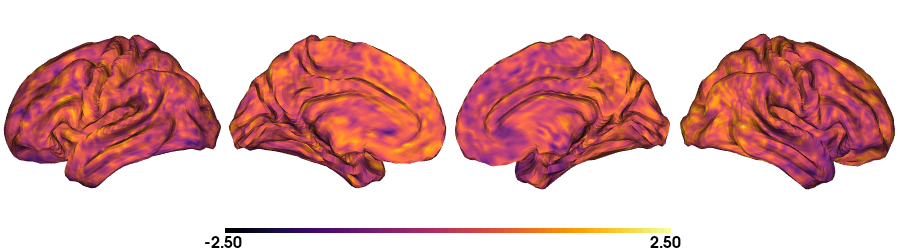


[main] 1 allPX, T1map, midthick
[1] L/R keys found
(4842,) (4842,)


### Δd (7T-3T): allPX, T1map, midthick surface

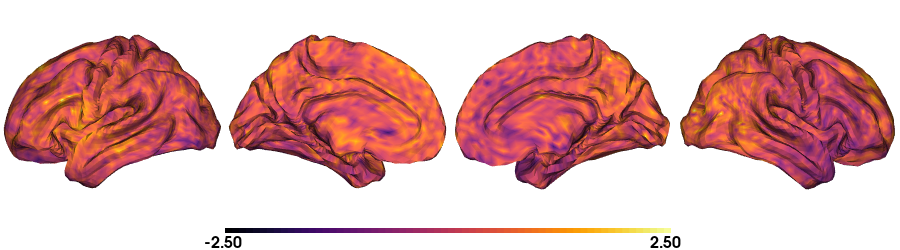


[main] 2 allPX, , thickness
[2] L/R keys found
(4842,) (4842,)


### Δd (7T-3T): allPX, , thickness surface

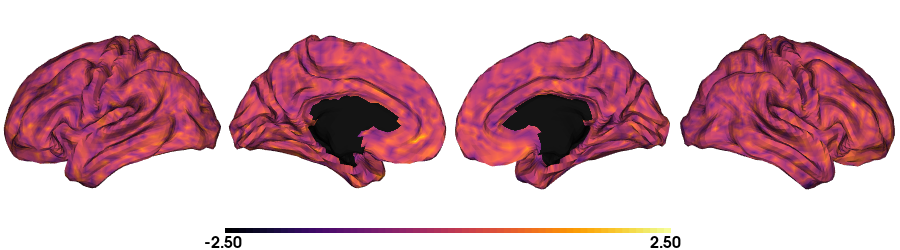


[main] 3 TLE_R, T1map, white
[3] ipsi/contra keys found. Using ipsiTo=L. SHOULD CHANGE TO READ ipsiTo FROM DICT.
(4842,) (4842,)


### Δd (7T-3T): TLE_R, T1map, white surface

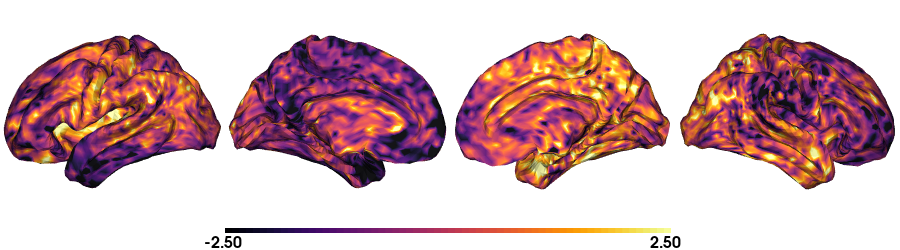


[main] 4 TLE_R, T1map, midthick
[4] ipsi/contra keys found. Using ipsiTo=L. SHOULD CHANGE TO READ ipsiTo FROM DICT.
(4842,) (4842,)


### Δd (7T-3T): TLE_R, T1map, midthick surface

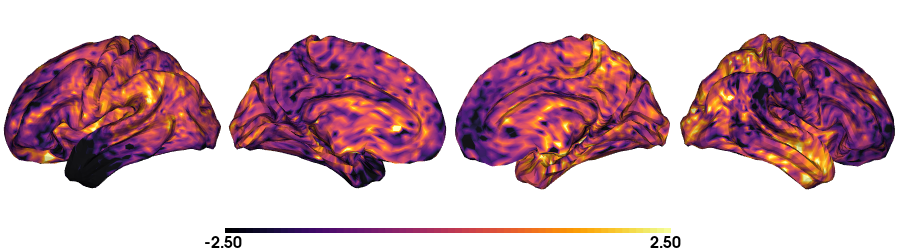


[main] 5 TLE_R, , thickness
[5] ipsi/contra keys found. Using ipsiTo=L. SHOULD CHANGE TO READ ipsiTo FROM DICT.
(4842,) (4842,)


### Δd (7T-3T): TLE_R, , thickness surface

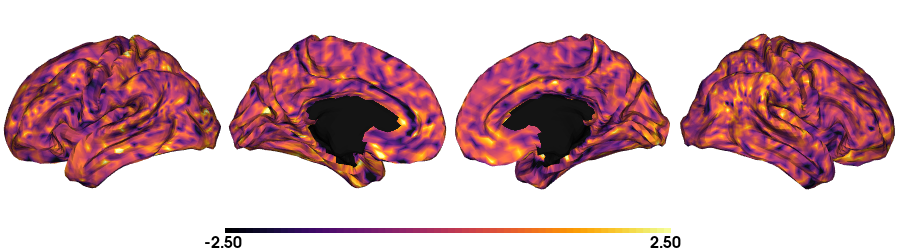


[main] 6 TLE_ic, T1map, white
[6] ipsi/contra keys found. Using ipsiTo=L. SHOULD CHANGE TO READ ipsiTo FROM DICT.
(4842,) (4842,)


### Δd (7T-3T): TLE_ic, T1map, white surface

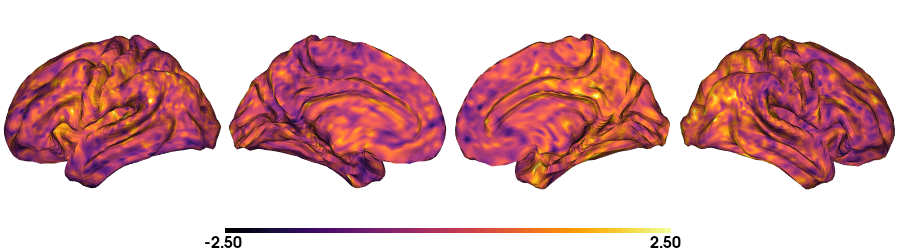


[main] 7 TLE_ic, T1map, midthick
[7] ipsi/contra keys found. Using ipsiTo=L. SHOULD CHANGE TO READ ipsiTo FROM DICT.
(4842,) (4842,)


### Δd (7T-3T): TLE_ic, T1map, midthick surface

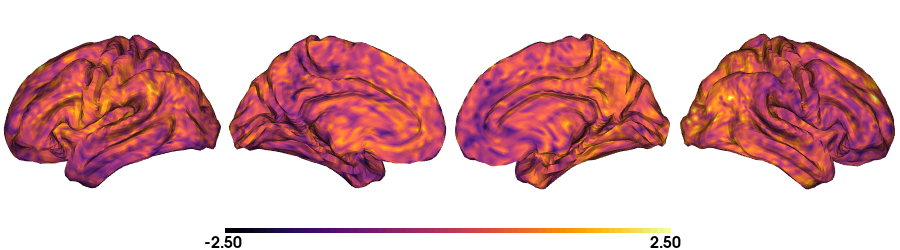


[main] 8 TLE_ic, , thickness
[8] ipsi/contra keys found. Using ipsiTo=L. SHOULD CHANGE TO READ ipsiTo FROM DICT.
(4842,) (4842,)


### Δd (7T-3T): TLE_ic, , thickness surface

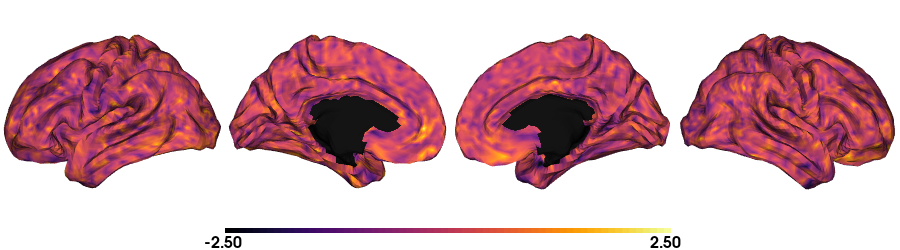


[main] 9 TLE_ic, T1map, white
[9] ipsi/contra keys found. Using ipsiTo=L. SHOULD CHANGE TO READ ipsiTo FROM DICT.
(4842,) (4842,)


### Δd (7T-3T): TLE_ic, T1map, white surface

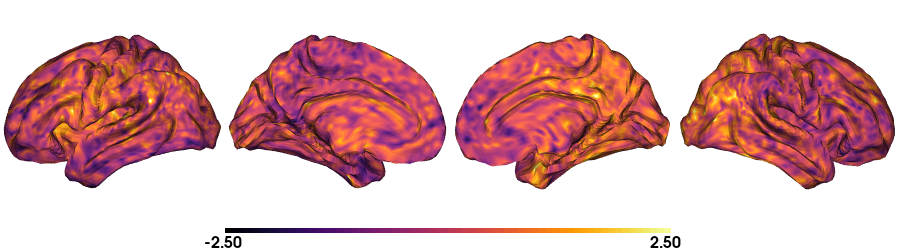


[main] 10 TLE_ic, T1map, midthick
[10] ipsi/contra keys found. Using ipsiTo=L. SHOULD CHANGE TO READ ipsiTo FROM DICT.
(4842,) (4842,)


### Δd (7T-3T): TLE_ic, T1map, midthick surface

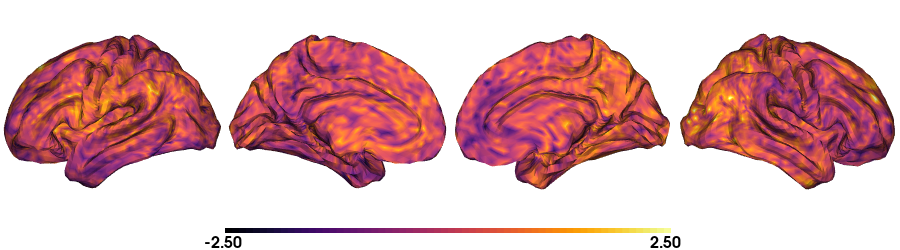


[main] 11 TLE_ic, , thickness
[11] ipsi/contra keys found. Using ipsiTo=L. SHOULD CHANGE TO READ ipsiTo FROM DICT.
(4842,) (4842,)


### Δd (7T-3T): TLE_ic, , thickness surface

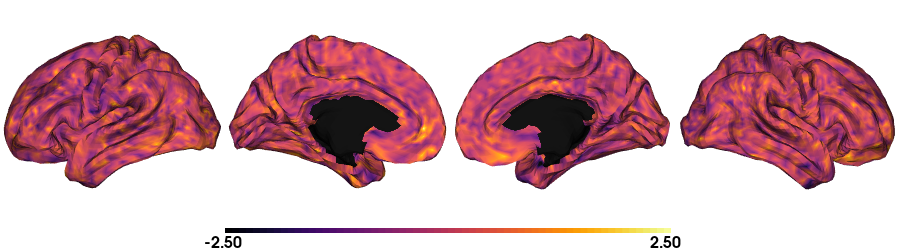


[main] 12 TLE_ic, T1map, white
[12] ipsi/contra keys found. Using ipsiTo=L. SHOULD CHANGE TO READ ipsiTo FROM DICT.
(4842,) (4842,)


### Δd (7T-3T): TLE_ic, T1map, white surface

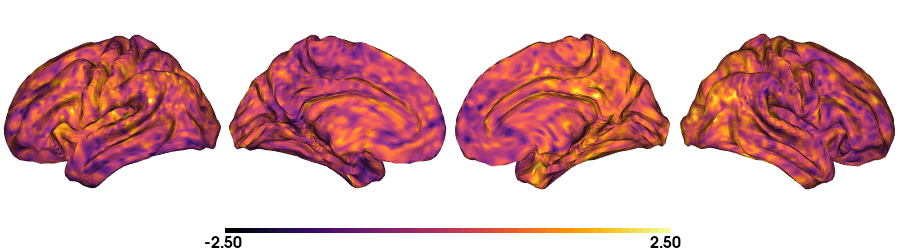


[main] 13 TLE_ic, T1map, midthick
[13] ipsi/contra keys found. Using ipsiTo=L. SHOULD CHANGE TO READ ipsiTo FROM DICT.
(4842,) (4842,)


### Δd (7T-3T): TLE_ic, T1map, midthick surface

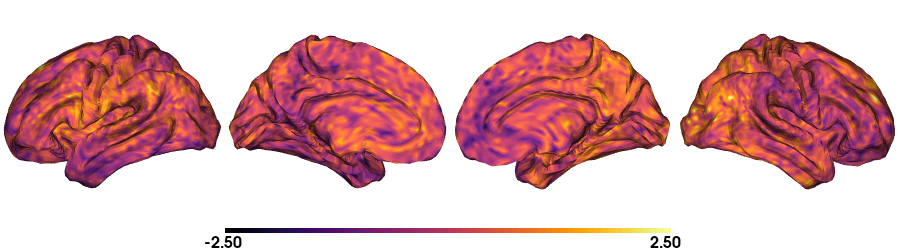


[main] 14 TLE_ic, , thickness
[14] ipsi/contra keys found. Using ipsiTo=L. SHOULD CHANGE TO READ ipsiTo FROM DICT.
(4842,) (4842,)


### Δd (7T-3T): TLE_ic, , thickness surface

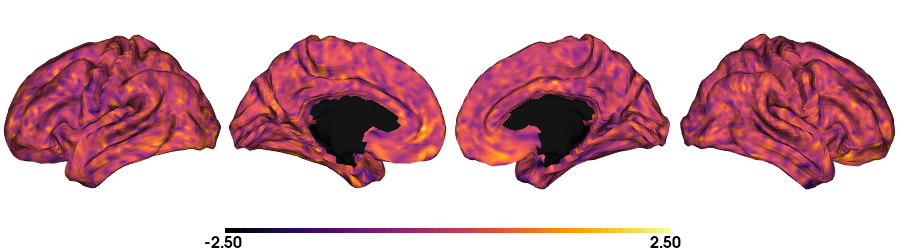

In [110]:
import datetime

save = False
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results/fig_stats/figs"
ipsiTo = None

for idx, i in enumerate(tTsT_comp):
    print(f"\n[main] {idx} {i['grp']}, {i['feature']}, {i['label']}")
    
    if 'stats_contra_dif' in i.keys() and 'stats_ipsi_dif' in i.keys():
        ic = True
        ipsiTo = "L" 
        print(f"[{idx}] ipsi/contra keys found. Using ipsiTo={ipsiTo}. SHOULD CHANGE TO READ ipsiTo FROM DICT.")
        if ipsiTo == "L":
            lh = i['stats_ipsi_dif']['d_dif']
            rh = i['stats_contra_dif']['d_dif']
            print(lh.shape, rh.shape)
            
        elif ipsiTo == "R":
            lh = i['stats_contra_dif']['d_dif']
            rh = i['stats_ipsi_dif']['d_dif']
            print(lh.shape, rh.shape)

    elif 'stats_L_dif' in i.keys() and 'stats_R_dif' in i.keys():
        print(f"[{idx}] L/R keys found")
        lh = i['stats_L_dif']['d_dif']
        rh = i['stats_R_dif']['d_dif']
        print(lh.shape, rh.shape)
    else:
        print(f"[{idx}] Neither contra/ipsi nor L/R keys found")
    
    fig_title = f"Δd (7T-3T): {i['grp']}, {i['feature']}, {i['label']} surface"

    name = f"dDif_{i['grp']}_{i['feature']}_{i['label']}"

    from IPython.display import display, Markdown
    display(Markdown(f"### {fig_title}"))
    
    if save == True:
        fig = showBrains(lh, rh, surface='fsLR-5k', min=-2.5, max=2.5, inflated=False, title = fig_title, save_name = name, save_pth=save_pth)
    else:
        fig = showBrains(lh, rh, surface='fsLR-5k', min=-2.5, max=2.5, inflated=False, title = fig_title)
    
    display(fig)
    

In [112]:
import datetime

save = False
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results/fig_stats/figs"
ipsiTo = None
metric = 't_dif' 

for idx, i in enumerate(tTsT_comp):
    print(f"\n[main] {idx} {i['grp']}, {i['feature']}, {i['label']}")
    
    if 'stats_contra_dif' in i.keys() and 'stats_ipsi_dif' in i.keys():
        ic = True
        ipsiTo = "L" 
        print(f"[{idx}] ipsi/contra keys found. Using ipsiTo={ipsiTo}. SHOULD CHANGE TO READ ipsiTo FROM DICT.")
        if ipsiTo == "L":
            lh = i['stats_ipsi_dif'][metric]
            rh = i['stats_contra_dif'][metric]
            print(lh.shape, rh.shape)
            
        elif ipsiTo == "R":
            lh = i['stats_contra_dif'][metric]
            rh = i['stats_ipsi_dif'][metric]
            print(lh.shape, rh.shape)

    elif 'stats_L_dif' in i.keys() and 'stats_R_dif' in i.keys():
        print(f"[{idx}] L/R keys found")
        lh = i['stats_L_dif'][metric]
        rh = i['stats_R_dif'][metric]
        print(lh.shape, rh.shape)
    else:
        print(f"[{idx}] Neither contra/ipsi nor L/R keys found")
    
    if metric == 'd_dif':
        metric_lbl = "Δd"
    elif metric == 't_dif':
        metric_lbl = "Δt"
    else:
        metric_lbl = metric

    fig_title = f"{metric_lbl} (7T-3T): {i['grp']}, {i['feature']}, {i['label']} surface"

    name = f"{metric}_{i['grp']}_{i['feature']}_{i['label']}"

    from IPython.display import display, Markdown
    display(Markdown(f"### {fig_title}"))
    #showBrains(lh, rh, surface='fsLR-5k', min=-2.5, max=2.5, inflated=False, title = fig_title, save_name = name, save_pth=save_pth)
    fig = showBrains(lh, rh, surface='fsLR-5k', ipsiTo = ipsiTo, min=-2.5, max=2.5, inflated=True, title = fig_title)
    # save figure
    if save == True:
        fig = showBrains(lh, rh, surface='fsLR-5k', min=-2.5, max=2.5, inflated=False, title = fig_title, save_name = name, save_pth=save_pth)
    else:
        fig = showBrains(lh, rh, surface='fsLR-5k', min=-2.5, max=2.5, inflated=False, title = fig_title)
    
    
    display(fig)


[main] 0 allPX, T1map, white
[0] L/R keys found
(4842,) (4842,)


### Δt (7T-3T): allPX, T1map, white surface

: 

In [ ]:
# TO DO: 
## Visualize 3T and 7T comparison maps
## Bar graphs for parcellations

NameError: name 'ipsiTo' is not defined

In [ ]:
# check correspondence between veretices L and R <optional: thorough>